---
Localization of Factor Models

---

# Preliminaries

In [ ]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 15.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from econml.grf import CausalForest
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import yfinance as yf



import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [3]:
path_prefix = 'data'


# Daily Analysis

## Data Preparation

In [ ]:
# Reload the file and read only rows 16 to 1188
data = pd.read_csv(path_prefix+'/25_Portfolios_5x5_Daily.csv', skiprows=18, nrows=25526)
data.head();

In [ ]:
# Convert the date column to datetime format and the returns columns to numerical values
data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

# Convert all other columns to numeric values
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Display the cleaned data
data.head()

Date  SMALL LoBM  ME1 BM2  ME1 BM3  ME1 BM4  SMALL HiBM  ME2 BM1  \
0 1926-07-01       -0.46     0.72     0.85     0.30       -0.57     0.34   
1 1926-07-02        0.57     0.77    -1.98    -0.41       -0.52     0.07   
2 1926-07-06        0.38    -0.46    -0.77     1.48       -0.28    -0.39   
3 1926-07-07       -0.81    -1.18     1.26     0.88       -0.61     0.63   
4 1926-07-08        0.56    -0.13    -1.10    -1.57        0.33     0.49   

   ME2 BM2  ME2 BM3  ME2 BM4  ...  ME4 BM1  ME4 BM2  ME4 BM3  ME4 BM4  \
0     1.73    -0.02    -0.55  ...     0.00     0.30    -0.32     0.02   
1    -0.06    -0.46    -0.03  ...    -0.03     0.09     1.04     0.49   
2    -0.04     0.35     0.07  ...     0.33     0.11     0.79    -0.11   
3    -0.59    -0.84    -1.31  ...     0.05     0.10     0.15     0.51   
4     0.81     0.30     0.17  ...     0.09     0.36     0.37     0.51   

   ME4 BM5  BIG LoBM  ME5 BM2  ME5 BM3  ME5 BM4  BIG HiBM  
0     0.41      0.32    -0.06     0.44    -0.31      0.40  
1     0.56      0.50     0.60     0.33     0.51      0.24  
2    -0.44      0.19     0.41    -0.12    -0.23      0.33  
3    -0.08     -0.05     0.39     0.09    -0.16      1.53  
4     1.27      0.41     0.36     0.01     0.16      0.22  

[5 rows x 26 columns]

In [ ]:
fama_french_data_path = path_prefix+'/F-F_Research_Data_Factors_daily.CSV'
fama_french_data = pd.read_csv(fama_french_data_path, skiprows=3)

# Display the first few rows of the Fama-French data to understand its structure
# Rename and convert the date column to datetime format in the Fama-French data
fama_french_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)


# Drop rows with NaN in the 'Date' column
fama_french_data.dropna(subset=['Date'], inplace=True)

# Remove non-numeric and footer rows from the Fama-French data
fama_french_data_cleaned = fama_french_data[fama_french_data['Date'].str.match(r'^\d+$')]

# Convert the 'Date' column to datetime format
fama_french_data_cleaned['Date'] = pd.to_datetime(fama_french_data_cleaned['Date'], format='%Y%m%d')

# Convert factor columns to numeric values
fama_french_data_cleaned[['Mkt-RF', 'SMB', 'HML', 'RF']] = fama_french_data_cleaned[['Mkt-RF', 'SMB', 'HML', 'RF']].apply(pd.to_numeric, errors='coerce')

# Display the first few rows of the cleaned Fama-French data
fama_french_data_cleaned.head()


Date  Mkt-RF   SMB   HML     RF
0 1926-07-01    0.10 -0.25 -0.27  0.009
1 1926-07-02    0.45 -0.33 -0.06  0.009
2 1926-07-06    0.17  0.30 -0.39  0.009
3 1926-07-07    0.09 -0.58  0.02  0.009
4 1926-07-08    0.21 -0.38  0.19  0.009

In [ ]:
# Fetch daily VIX data from Yahoo Finance starting from 1990
vix_data = yf.download("^VIX", start="1980-01-01", end="2024-05-26")['Adj Close']
vix_data.rename('VIX', inplace = True)

In [ ]:
# Merge the portfolio returns data with the cleaned Fama-French data on the Date column
merged_data = pd.merge(data, fama_french_data_cleaned, on='Date', how='inner')
merged_data = pd.merge(merged_data, vix_data, on='Date', how='inner')

merged_data.head()

Date  SMALL LoBM  ME1 BM2  ME1 BM3  ME1 BM4  SMALL HiBM  ME2 BM1  \
0 1990-01-02        0.84     0.81     0.99     1.11        1.47     0.91   
1 1990-01-03        0.69     0.93     0.88     0.63        0.99     0.66   
2 1990-01-04       -0.16    -0.53    -0.25    -0.43       -0.11    -0.41   
3 1990-01-05        0.05     0.11    -0.11    -0.08        0.05    -0.49   
4 1990-01-08        0.19     0.18     0.20     0.11       -0.19     0.34   

   ME2 BM2  ME2 BM3  ME2 BM4  ...  BIG LoBM  ME5 BM2  ME5 BM3  ME5 BM4  \
0     0.69     0.76     0.74  ...      1.67     2.41     0.98     1.33   
1     0.45     0.81     0.36  ...      0.16     0.10    -0.42    -0.50   
2    -0.42    -0.20    -0.47  ...     -0.88    -0.43    -0.84    -1.31   
3    -0.19    -0.24    -0.18  ...     -0.90    -0.87    -0.90    -1.49   
4    -0.05    -0.28    -0.24  ...      0.31     0.68     0.63     0.62   

   BIG HiBM  Mkt-RF   SMB   HML     RF        VIX  
0      1.95    1.44 -0.68 -0.07  0.026  17.240000  
1     -0.69   -0.06  0.73 -0.26  0.026  18.190001  
2     -0.94   -0.71  0.42 -0.22  0.026  19.219999  
3     -1.22   -0.85  0.77 -0.21  0.026  20.110001  
4      0.16    0.30 -0.41 -0.26  0.026  20.260000  

[5 rows x 31 columns]

## Beta analysis

### CAPM Regression for Portfolio Excess Returns

In [ ]:


# Calculate excess returns for each portfolio by subtracting the risk-free rate
excess_returns = merged_data.iloc[:, 1:26].subtract(merged_data['RF'], axis=0)

# Store the results of the CAPM regression for each portfolio
capm_results = {}
n =  np.shape(merged_data)[0]
# Run CAPM regression for each portfolio


for column in excess_returns.columns:
  model_beta = []
  for i in range(100):
    indices = np.random.choice(n, int(0.8 * n ), replace=True)
    Y = excess_returns[column][indices]
    X = merged_data['Mkt-RF'][indices]
    #X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(Y, X).fit()  # Fit the regression model
    model_beta.append(model.params[0])


  capm_results[column] = np.array(model_beta)  # Store the summary of the model

# Display the CAPM results for the first portfolio as an example



### Bootstrap of Conditional R-Squared for Portfolio Returns with VIX

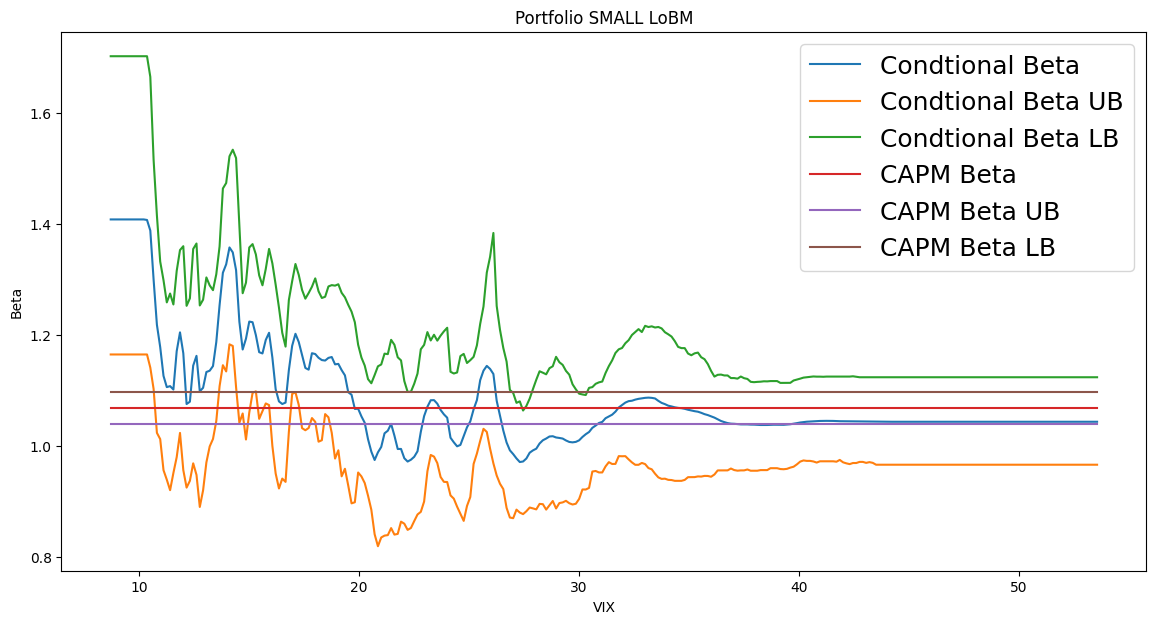

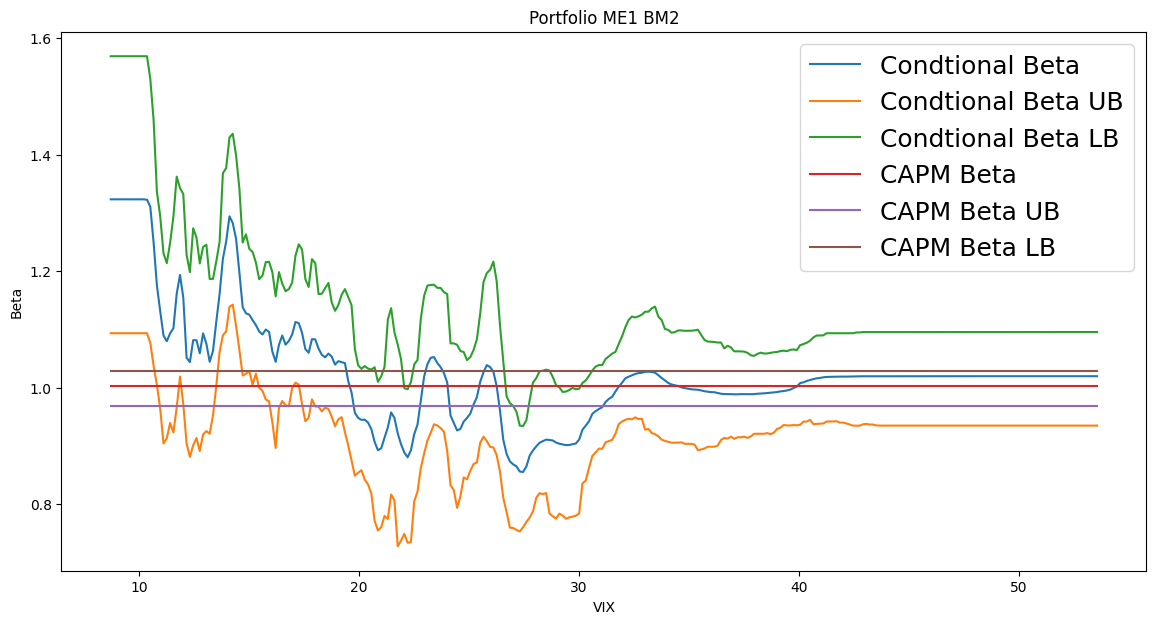

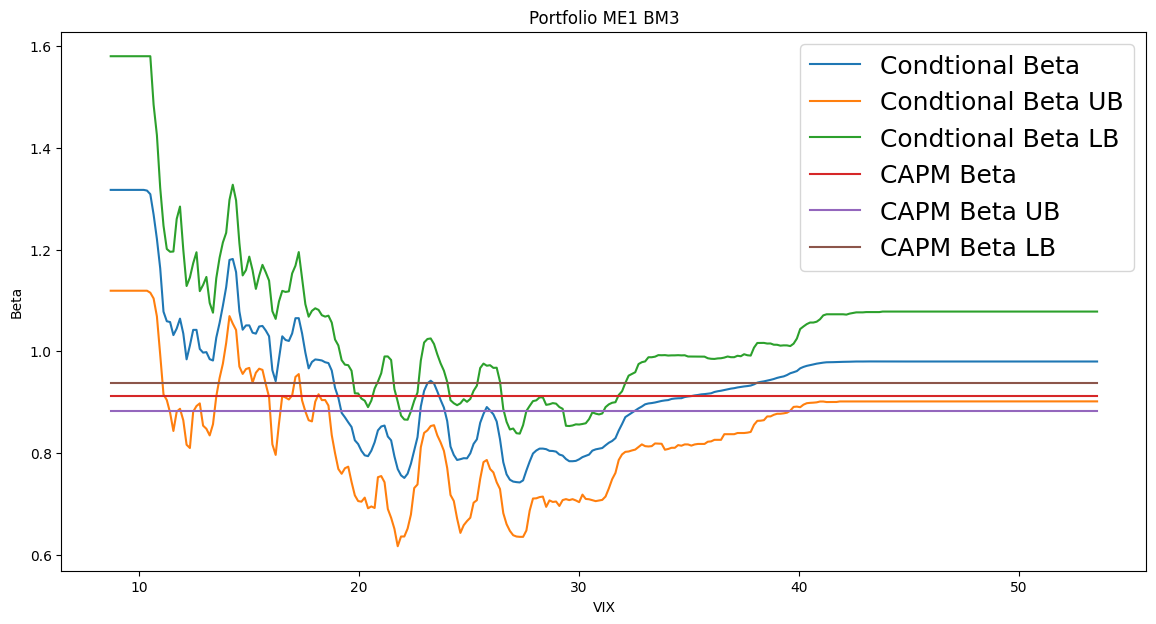

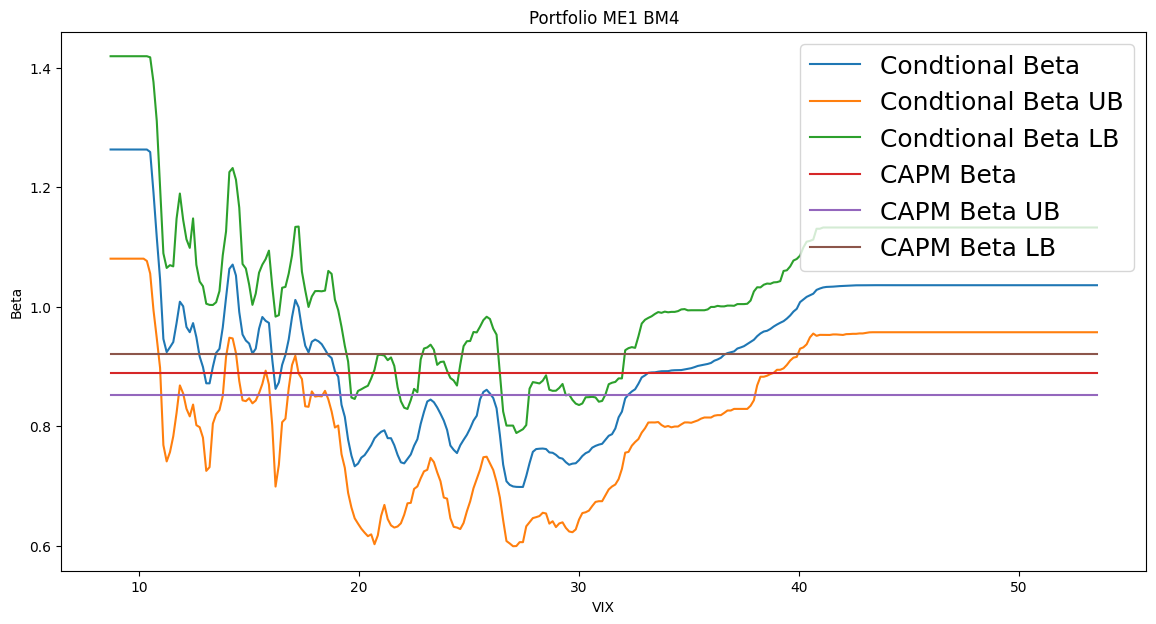

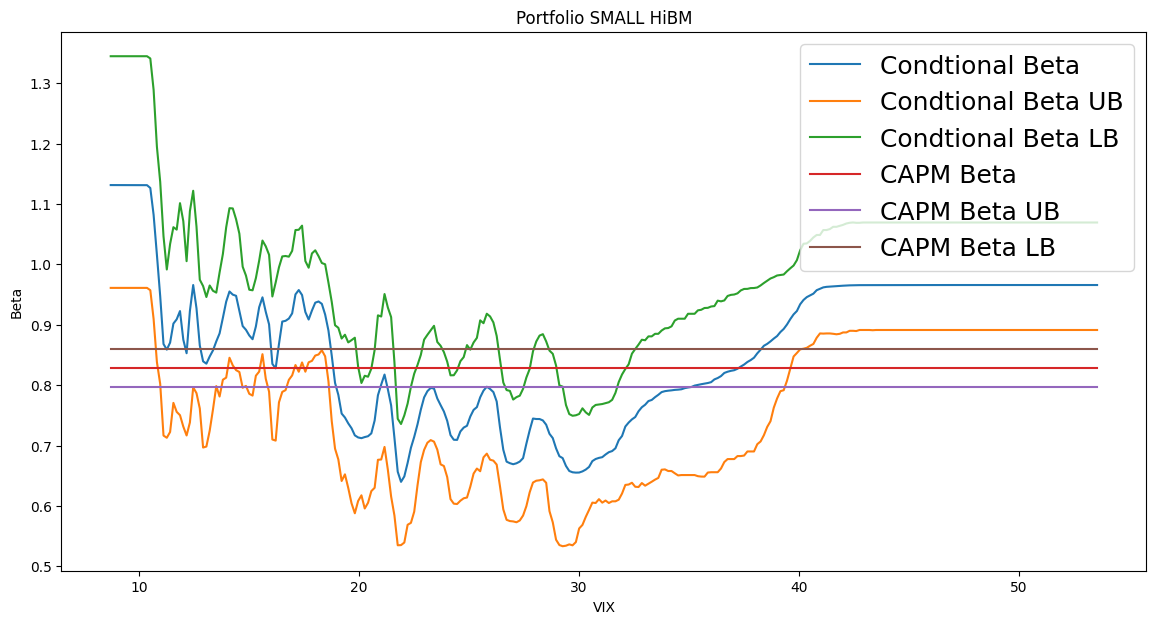

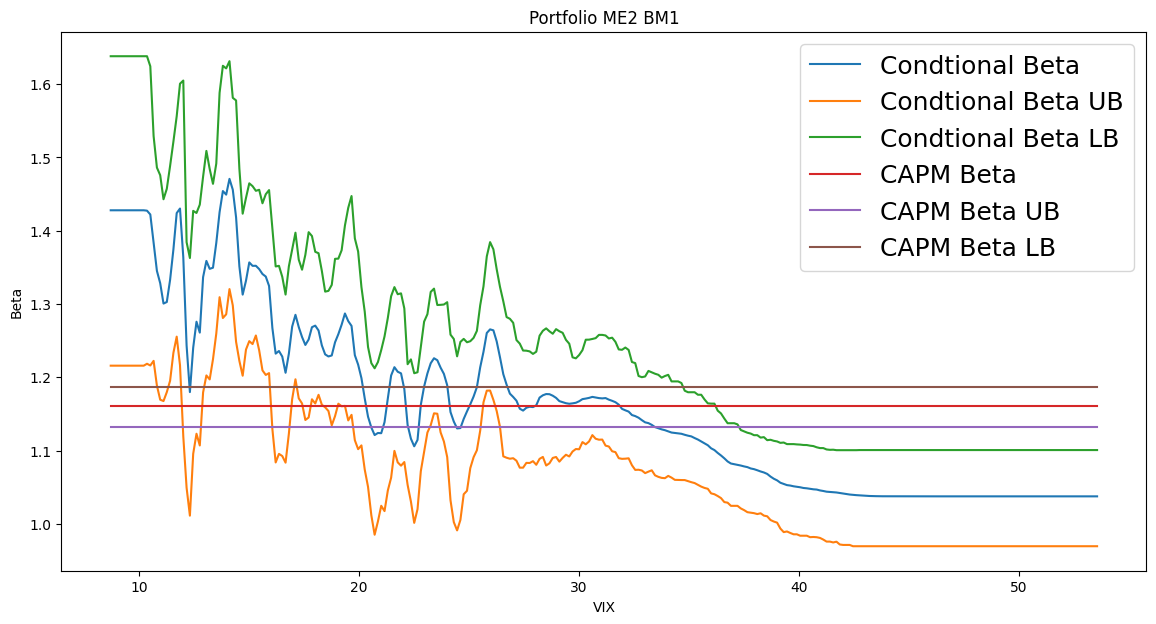

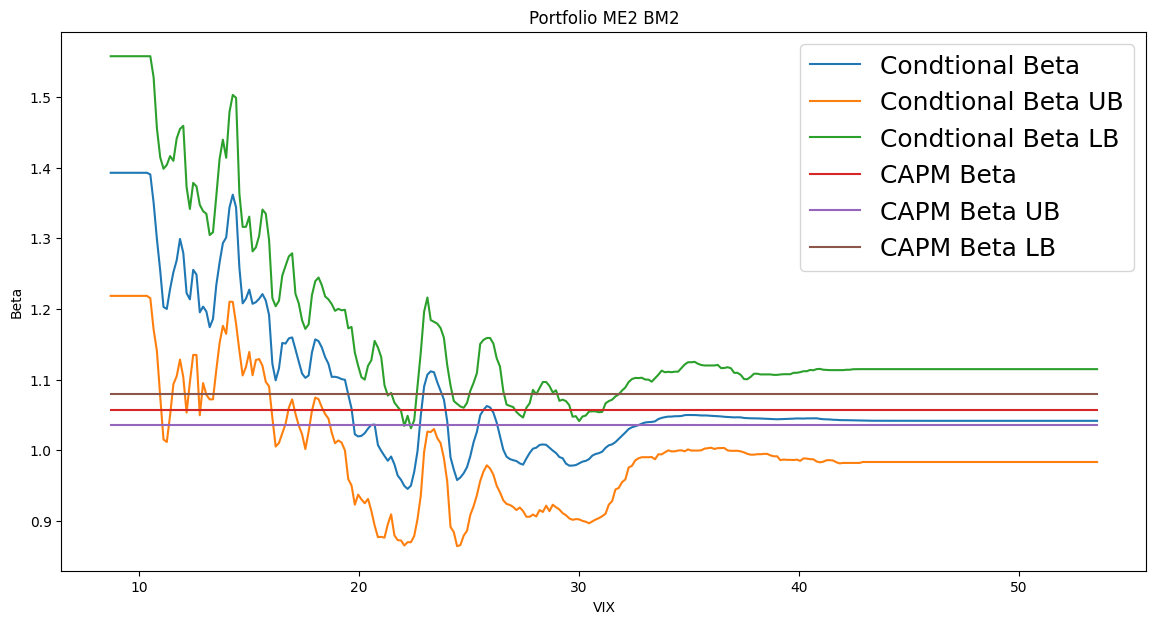

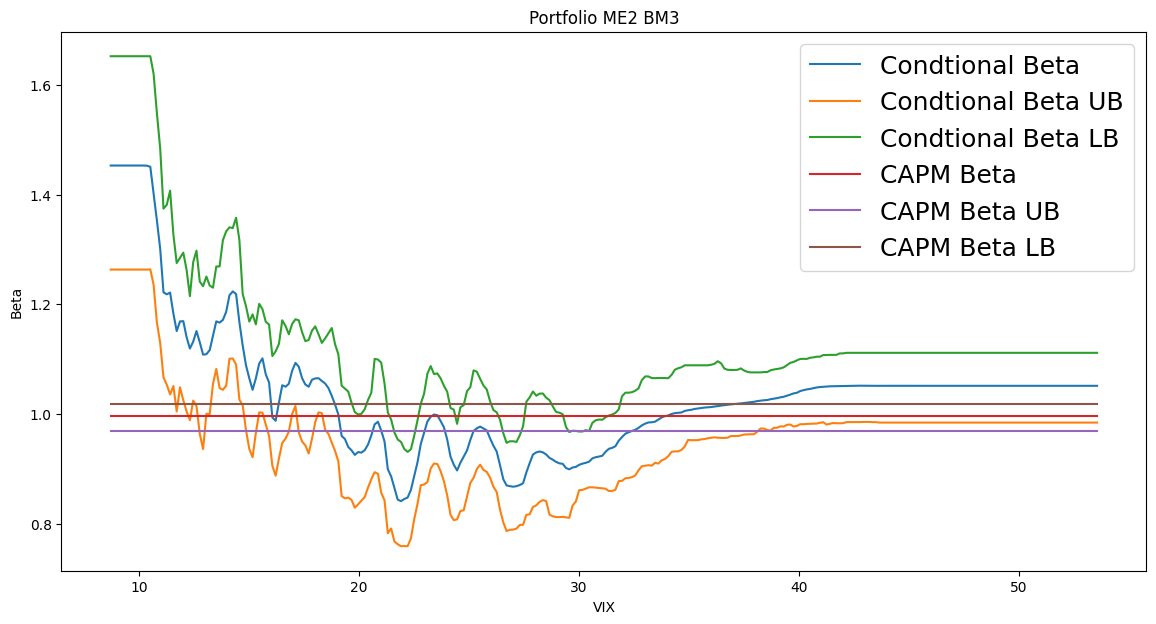

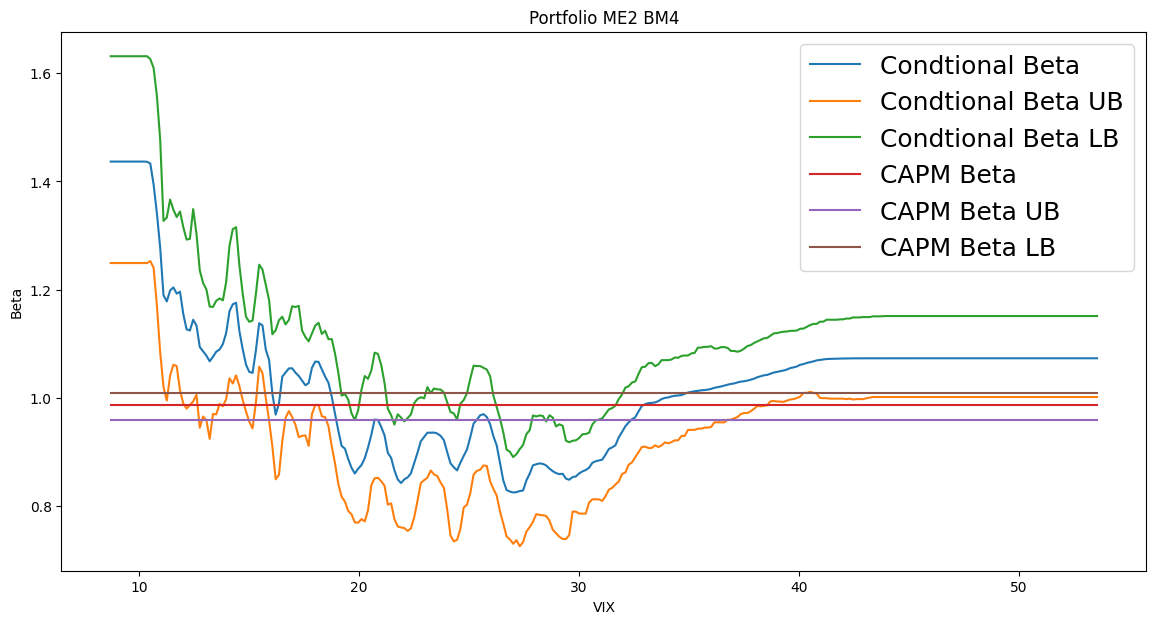

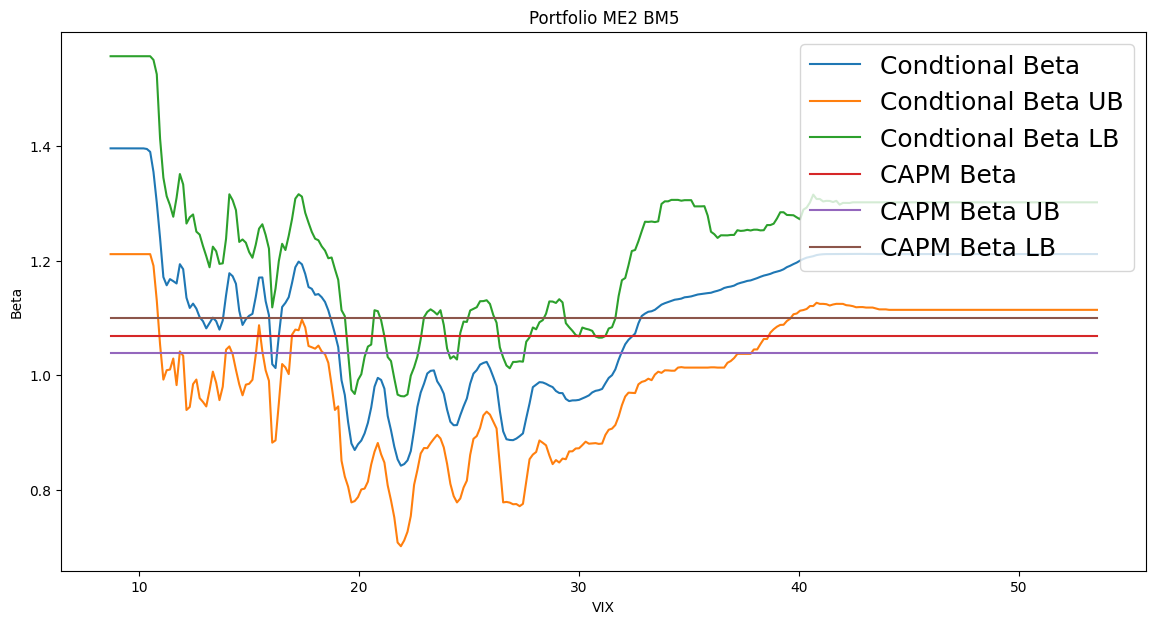

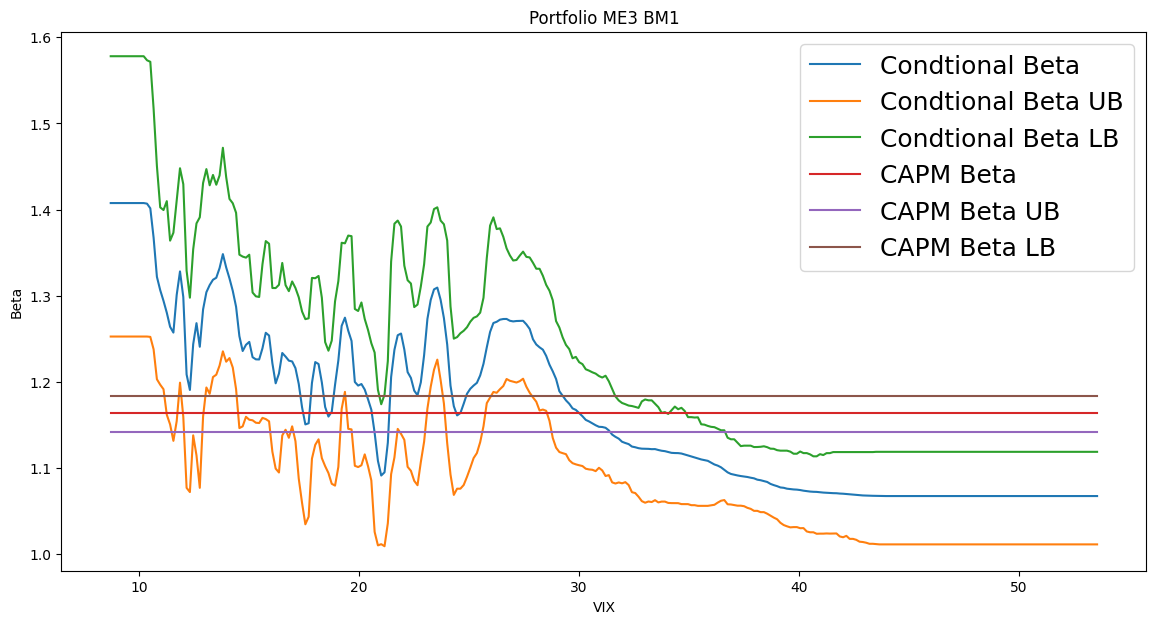

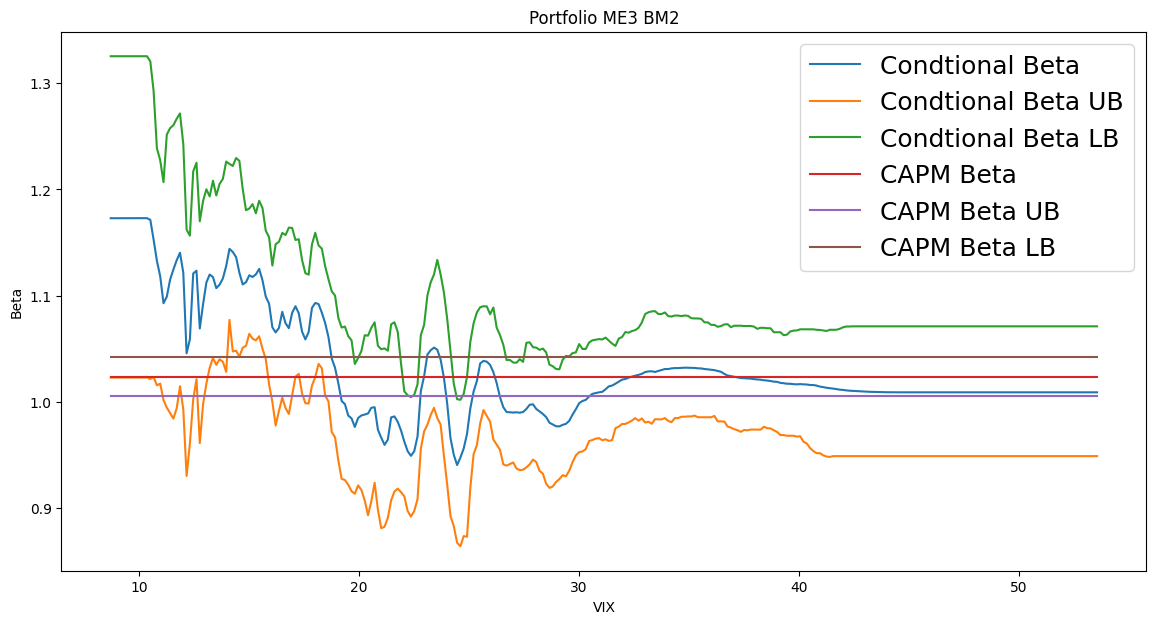

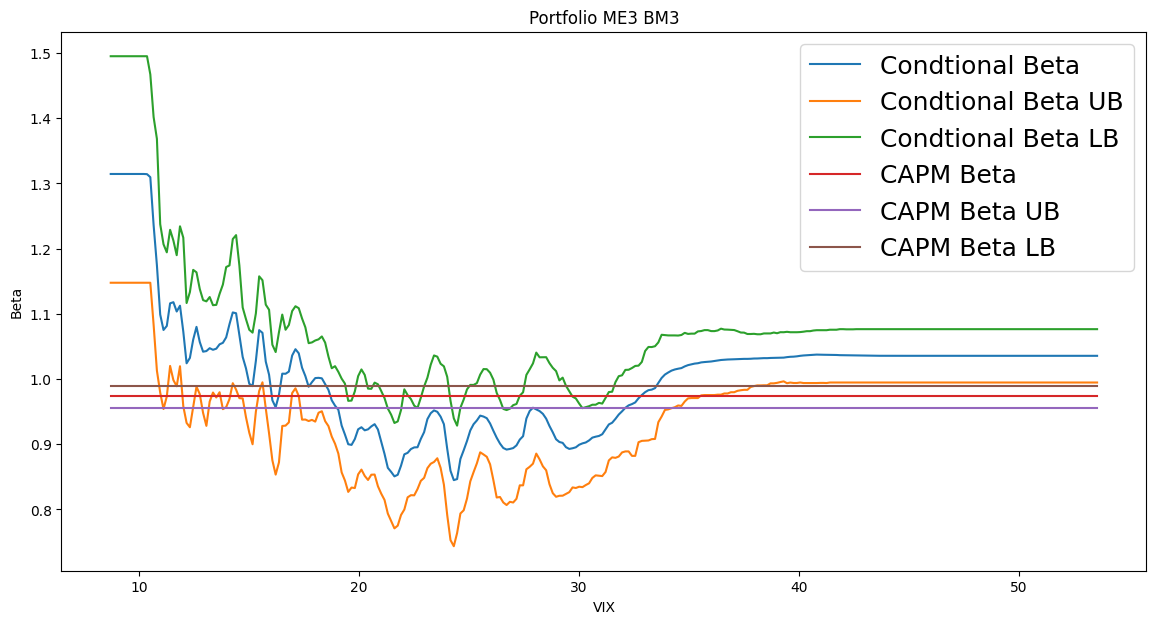

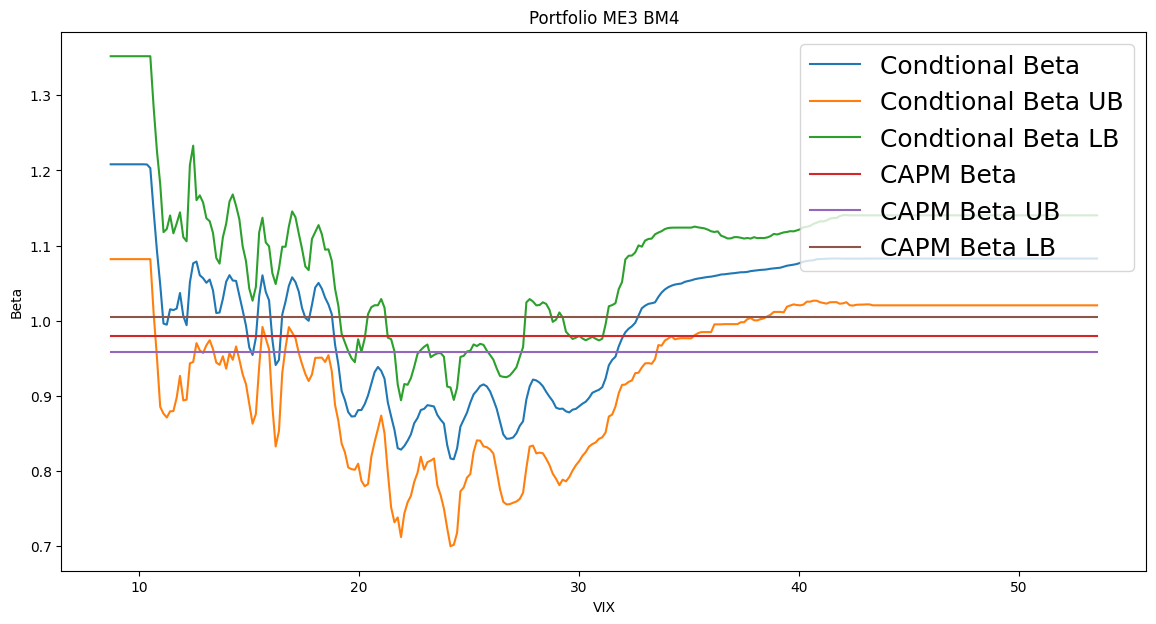

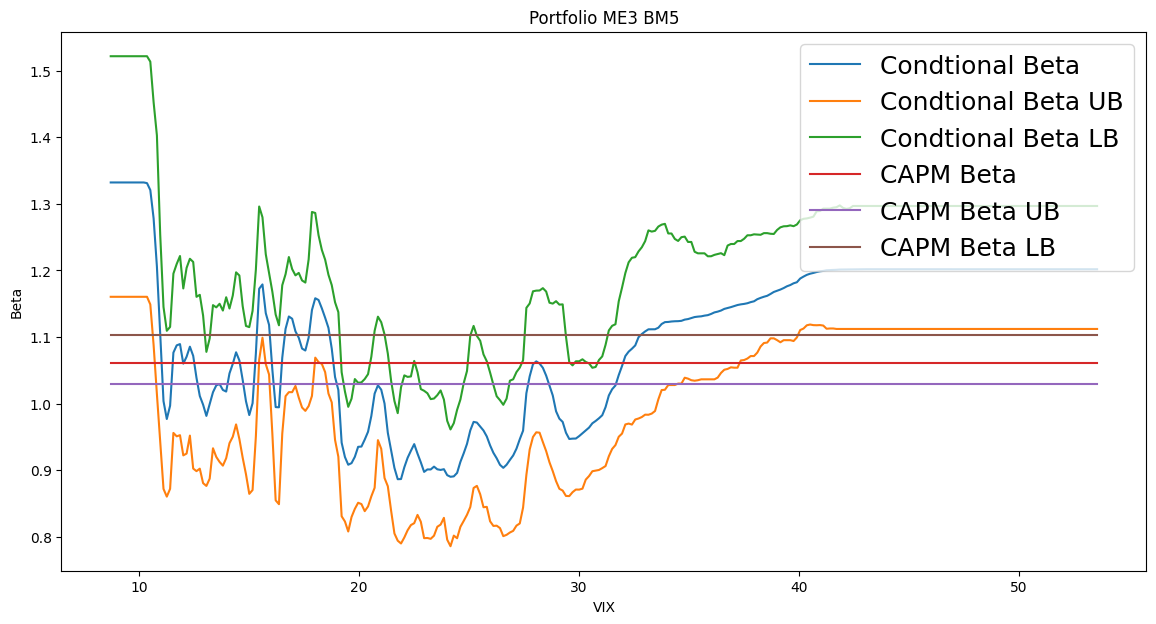

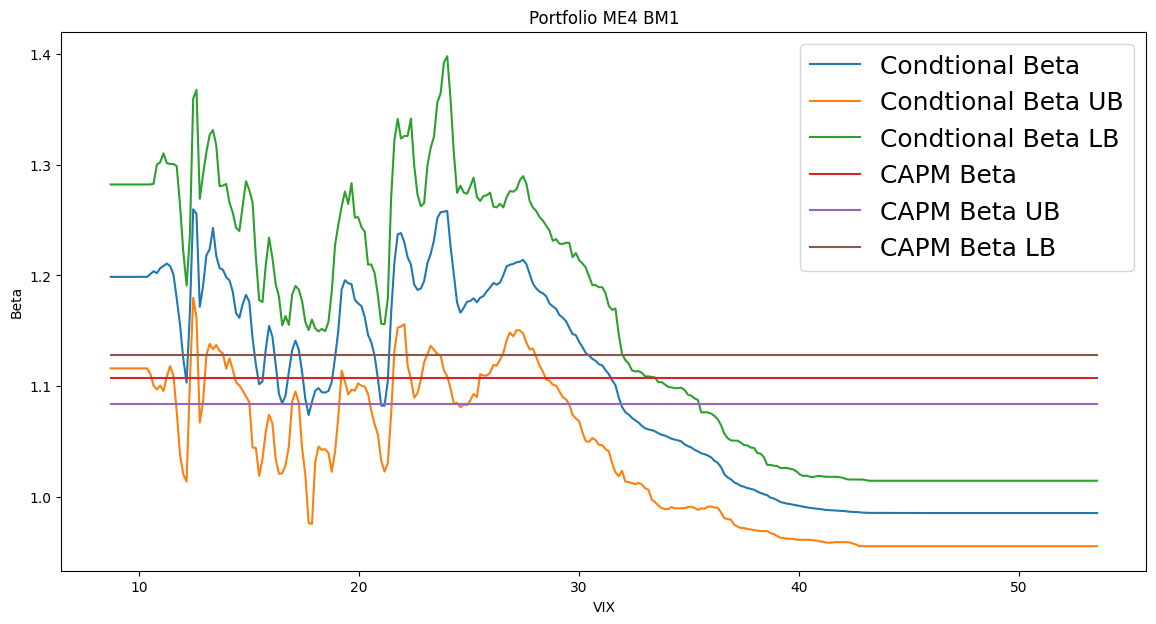

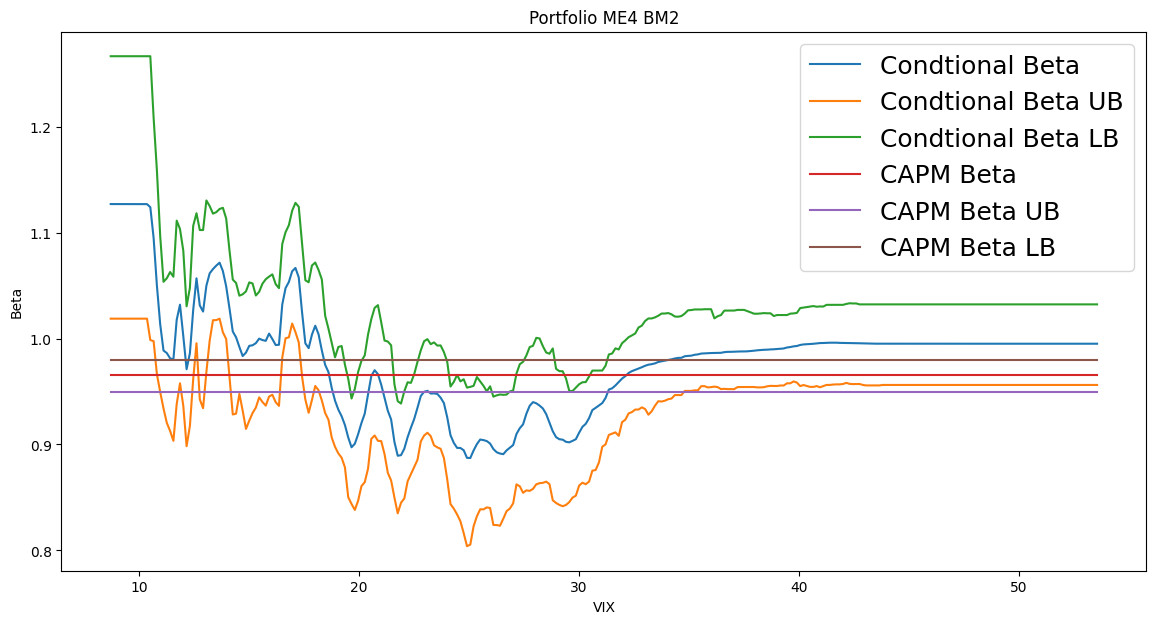

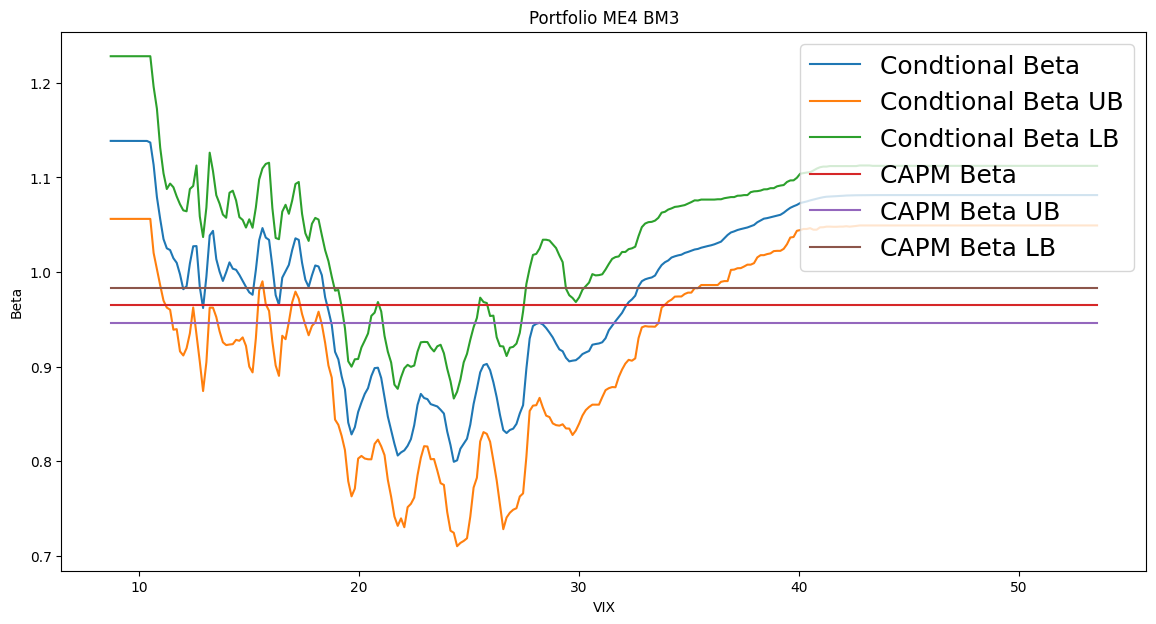

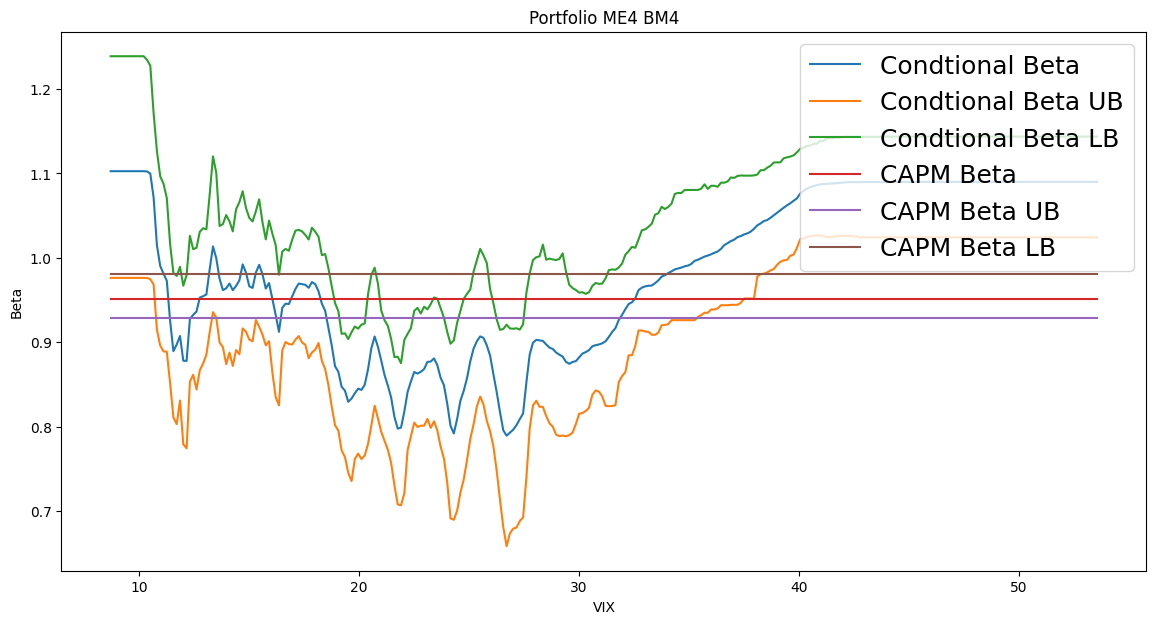

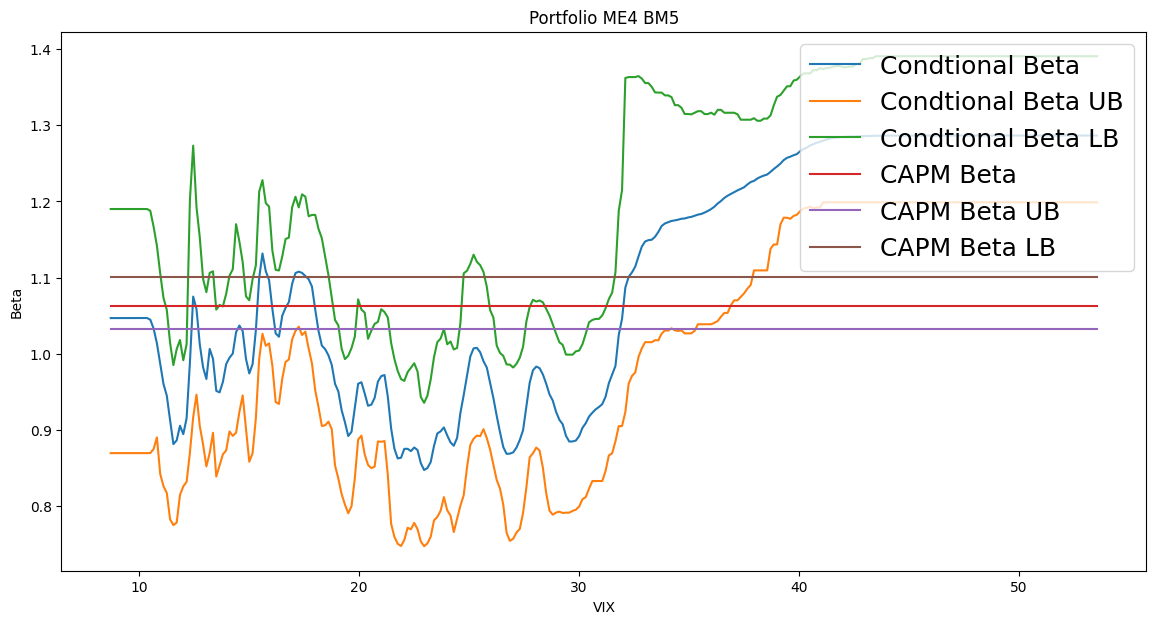

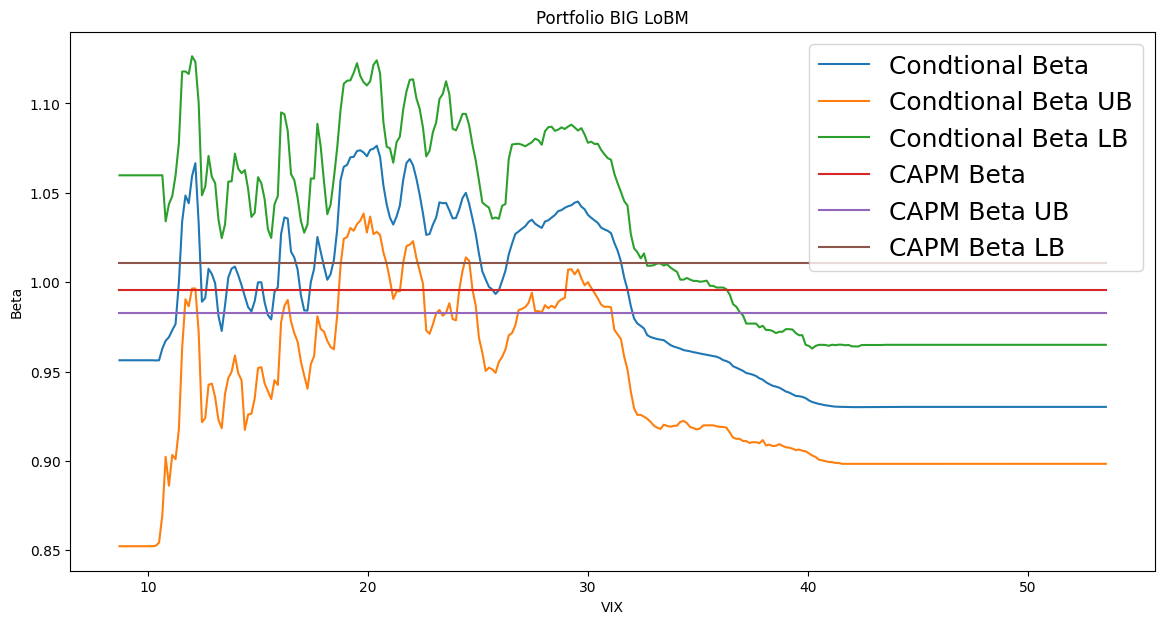

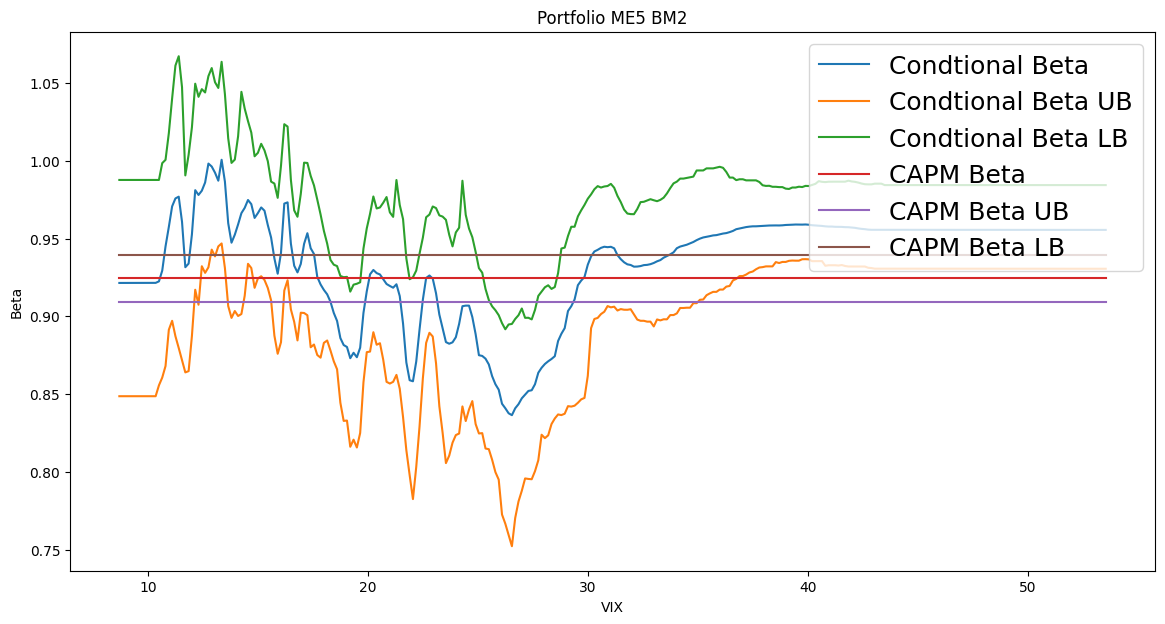

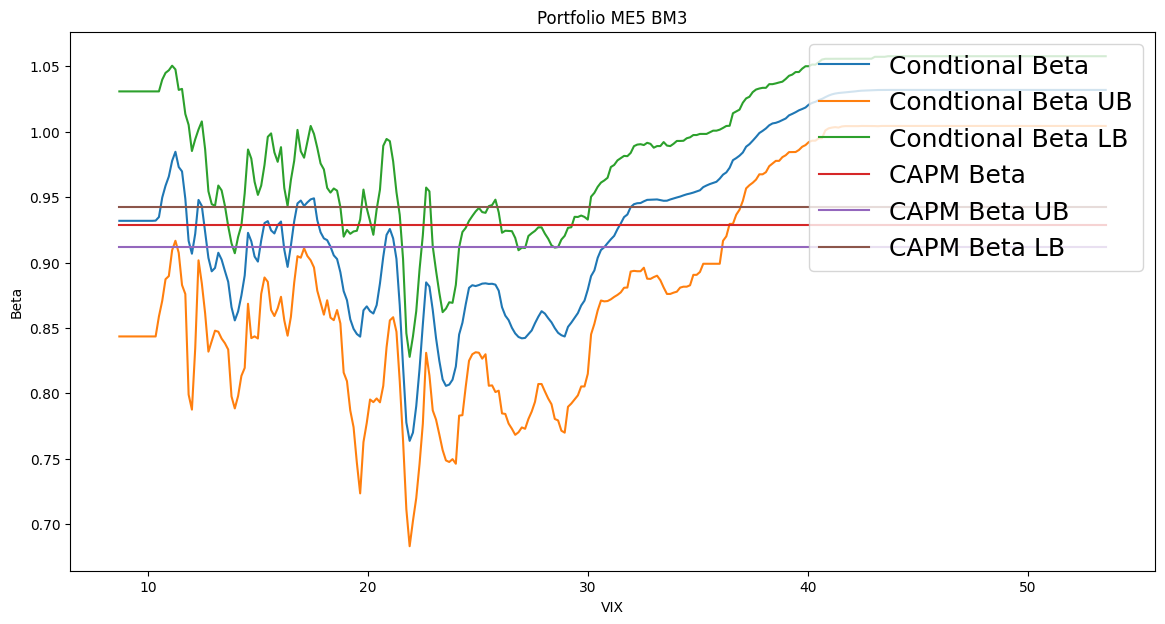

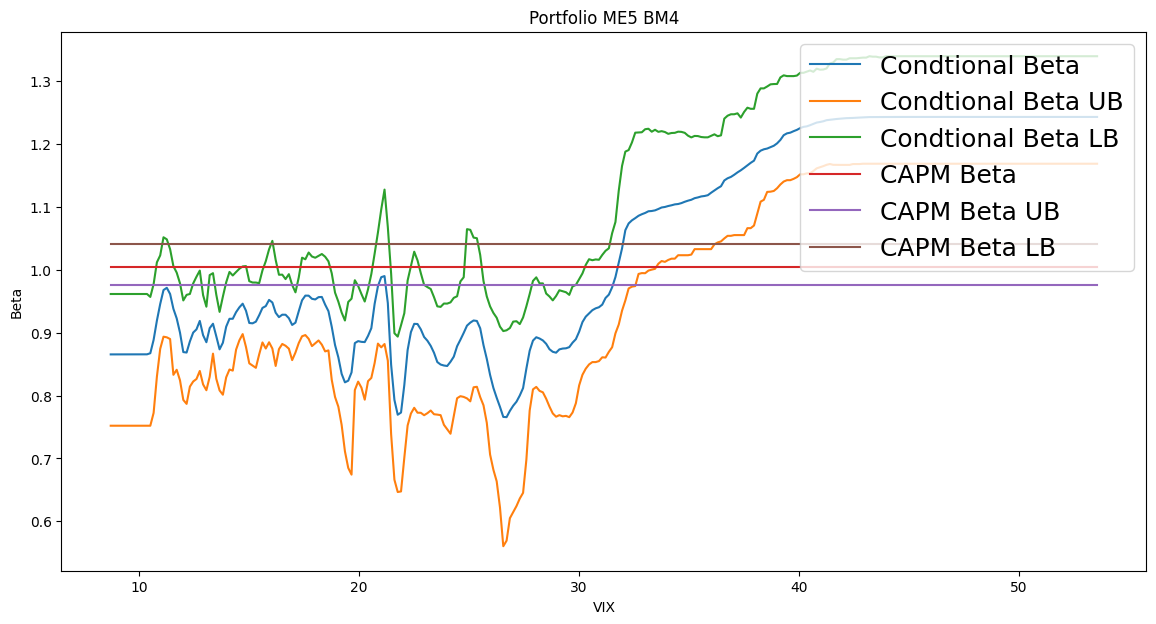

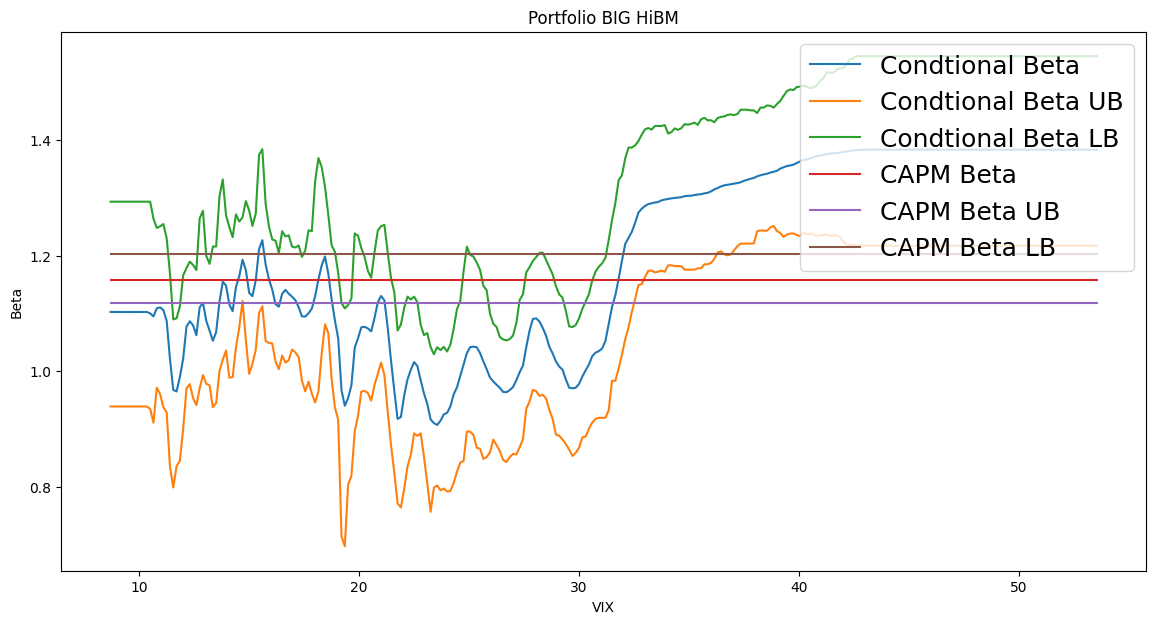

In [ ]:
test_data = np.array([[8.7 + i * 0.15] for i in range(300)])
result_beta = {}
for portfolio in excess_returns.columns:

  corr_bootstrap = np.array([])
  for i in range(100):
    n =  np.shape(merged_data)[0]
    indices = np.random.choice(n, int(0.8 * n ), replace=True)
    final_data = merged_data.iloc[indices,:]
    Y = final_data[portfolio] - final_data['RF']

    # Define the treatment variable (market excess return)
    T = final_data['Mkt-RF']

    # Define the covariates (features), including the VIX
    X = final_data[['VIX']]


    # Instantiate the Causal Forest model
    causal_forest = CausalForest(min_samples_leaf = 30)
    causal_forest.fit(X, T,Y)

    # Make predictions (treatment effects)
    beta_iM = np.squeeze(causal_forest.predict(test_data)[:,0])



    cond_r_sqaure = beta_iM
    corr_bootstrap = np.append(corr_bootstrap ,cond_r_sqaure)



  t = np.reshape(corr_bootstrap,(100,300))
  data = pd.DataFrame({'Condtional Beta' : np.mean(t, axis = 0) ,
        'Condtional Beta UB':  np.sort(t, axis=0)[2,:]
  ,

          'Condtional Beta LB' :np.sort(t, axis=0)[-3,:]  ,
        'CAPM Beta': np.ones(300) * np.mean(capm_results[portfolio]),
                        'CAPM Beta UB': np.ones(300) * np.sort(capm_results[portfolio])[2]
                       , 'CAPM Beta LB': np.ones(300) * np.sort(capm_results[portfolio])[-3]
                      })


  
  plt.figure(figsize=(14, 7))

  for column in data.columns:
      plt.plot( np.squeeze(test_data), data[column], label=column)

  # Adding labels and title
  plt.xlabel('VIX')
  plt.ylabel('Beta')
  plt.title('Portfolio ' + portfolio)
  plt.legend(fontsize=18, loc='upper right')
  


  # Show the plot
  plt.show()


## $R^2$ analysis

In [ ]:


# Calculate excess returns for each portfolio by subtracting the risk-free rate
excess_returns = merged_data.iloc[:, 1:26].subtract(merged_data['RF'], axis=0)

# Store the results of the CAPM regression for each portfolio
capm_results = {}
n =  np.shape(merged_data)[0]
# Run CAPM regression for each portfolio


for column in excess_returns.columns:
  model_rsqure = []
  for i in range(100):
    indices = np.random.choice(n, int(0.8 * n ), replace=True)
    Y = excess_returns[column][indices]
    X = merged_data['Mkt-RF'][indices]
    #X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(Y, X).fit()  # Fit the regression model
    model_rsqure.append(model.rsquared)


  capm_results[column] = np.array(model_rsqure)  # Store the summary of the model

# Display the CAPM results for the first portfolio as an example



In [ ]:
results = {}


test_data = np.array([[8.7 + i * 0.15] for i in range(300)])
for portfolio in excess_returns.columns:

  corr_bootstrap = np.array([])
  for i in range(100):
    n =  np.shape(merged_data)[0]
    indices = np.random.choice(n, int(0.8 * n ), replace=True)
    final_data = merged_data.iloc[indices,:]
    Y = final_data[portfolio] - final_data['RF']

    # Define the treatment variable (market excess return)
    T = final_data['Mkt-RF']

    # Define the covariates (features), including the VIX
    X = final_data[['VIX']]


    # Instantiate the Causal Forest model
    causal_forest = CausalForest(min_samples_leaf = 30)
    causal_forest.fit(X, T,Y)

    # Make predictions (treatment effects)
    beta_iM = np.squeeze(causal_forest.predict(test_data)[:,0])

    causal_forest = CausalForest(min_samples_leaf = 30)

    causal_forest.fit(X,Y,T)

    # Make predictions (treatment effects)
    beta_Mi = np.squeeze(causal_forest.predict(test_data)[:,0])

    cond_r_sqaure = beta_iM * beta_Mi
    corr_bootstrap = np.append(corr_bootstrap ,cond_r_sqaure)



  t = np.reshape(corr_bootstrap,(100,300))
  data = pd.DataFrame({'Condtional R sqaure' : np.mean(t, axis = 0) ,
        'Condtional R sqaure UB':  np.sort(t, axis=0)[2,:]
  ,

          'Condtional R sqaure LB' :np.sort(t, axis=0)[-3,:]  ,
        'CAPM R sqaure': np.ones(300) * np.mean(capm_results[portfolio]),
                        'CAPM R sqaure UB': np.ones(300) * np.sort(capm_results[portfolio])[2]
                       , 'CAPM R sqaure LB': np.ones(300) * np.sort(capm_results[portfolio])[-3]
                      })



  plt.figure(figsize=(14, 7))
  data_json =  data.copy()
  data_json['VIX'] = np.squeeze(test_data)
  data_json = data_json.to_json()
  results[portfolio] = data_json

  for column in data.columns:
      plt.plot( np.squeeze(test_data), data[column], label=column)

  # Adding labels and title
  plt.xlabel('VIX')
  plt.ylabel('R Square')
  plt.title('Portfolio ' + portfolio)
  plt.legend(fontsize=18, loc='lower right')

  


  # Show the plot
  plt.show()


# Fama-French Model

## Data Preparation

In [ ]:
# Reload the file and read only rows 16 to 1188
data = pd.read_csv(path_prefix+'/25_Portfolios_5x5_Daily.csv', skiprows=18, nrows=25526)
data.head();

# Convert the date column to datetime format and the returns columns to numerical values
data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

# Convert all other columns to numeric values
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')


fama_french_data_path = path_prefix+'/F-F_Research_Data_Factors_daily.CSV'
fama_french_data = pd.read_csv(fama_french_data_path, skiprows=3)

# Rename and convert the date column to datetime format in the Fama-French data
fama_french_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)


# Drop rows with NaN in the 'Date' column
fama_french_data.dropna(subset=['Date'], inplace=True)

# Remove non-numeric and footer rows from the Fama-French data
fama_french_data_cleaned = fama_french_data[fama_french_data['Date'].str.match(r'^\d+$')]

# Convert the 'Date' column to datetime format
fama_french_data_cleaned['Date'] = pd.to_datetime(fama_french_data_cleaned['Date'], format='%Y%m%d')

# Convert factor columns to numeric values
fama_french_data_cleaned[['Mkt-RF', 'SMB', 'HML', 'RF']] = fama_french_data_cleaned[['Mkt-RF', 'SMB', 'HML', 'RF']].apply(pd.to_numeric, errors='coerce')



# Fetch daily VIX data from Yahoo Finance starting from 1990
vix_data = yf.download("^VIX", start="1980-01-01", end="2024-05-26")['Adj Close']
vix_data.rename('VIX', inplace = True)

# Merge the portfolio returns data with the cleaned Fama-French data on the Date column
merged_data = pd.merge(data, fama_french_data_cleaned, on='Date', how='inner')
merged_data = pd.merge(merged_data, vix_data, on='Date', how='inner')

merged_data.head()

[*********************100%%**********************]  1 of 1 completed


Date  SMALL LoBM  ME1 BM2  ME1 BM3  ME1 BM4  SMALL HiBM  ME2 BM1  \
0 1990-01-02        0.84     0.81     0.99     1.11        1.47     0.91   
1 1990-01-03        0.69     0.93     0.88     0.63        0.99     0.66   
2 1990-01-04       -0.16    -0.53    -0.25    -0.43       -0.11    -0.41   
3 1990-01-05        0.05     0.11    -0.11    -0.08        0.05    -0.49   
4 1990-01-08        0.19     0.18     0.20     0.11       -0.19     0.34   

   ME2 BM2  ME2 BM3  ME2 BM4  ...  BIG LoBM  ME5 BM2  ME5 BM3  ME5 BM4  \
0     0.69     0.76     0.74  ...      1.67     2.41     0.98     1.33   
1     0.45     0.81     0.36  ...      0.16     0.10    -0.42    -0.50   
2    -0.42    -0.20    -0.47  ...     -0.88    -0.43    -0.84    -1.31   
3    -0.19    -0.24    -0.18  ...     -0.90    -0.87    -0.90    -1.49   
4    -0.05    -0.28    -0.24  ...      0.31     0.68     0.63     0.62   

   BIG HiBM  Mkt-RF   SMB   HML     RF        VIX  
0      1.95    1.44 -0.68 -0.07  0.026  17.240000  
1     -0.69   -0.06  0.73 -0.26  0.026  18.190001  
2     -0.94   -0.71  0.42 -0.22  0.026  19.219999  
3     -1.22   -0.85  0.77 -0.21  0.026  20.110001  
4      0.16    0.30 -0.41 -0.26  0.026  20.260000  

[5 rows x 31 columns]

## Beta analysis

In [ ]:
capm_results = {}
excess_returns = merged_data.iloc[:, 1:26].subtract(merged_data['RF'], axis=0)


In [ ]:

# Store the results of the CAPM regression for each portfolio
capm_results = {}
n =  np.shape(merged_data)[0]
# Run CAPM regression for each portfolio


for column in excess_returns.columns:
  model_beta = []


  Y = excess_returns[column]
  X = merged_data[['Mkt-RF', 'SMB', 'HML']]
  #X = sm.add_constant(X)  # Adds a constant term to the predictor

  model = sm.OLS(Y, X).fit()  # Fit the regression model


  capm_results[column] = np.array(model.params[0:3])  # Store the summary of the model

# Display the CAPM results for the first portfolio as an example



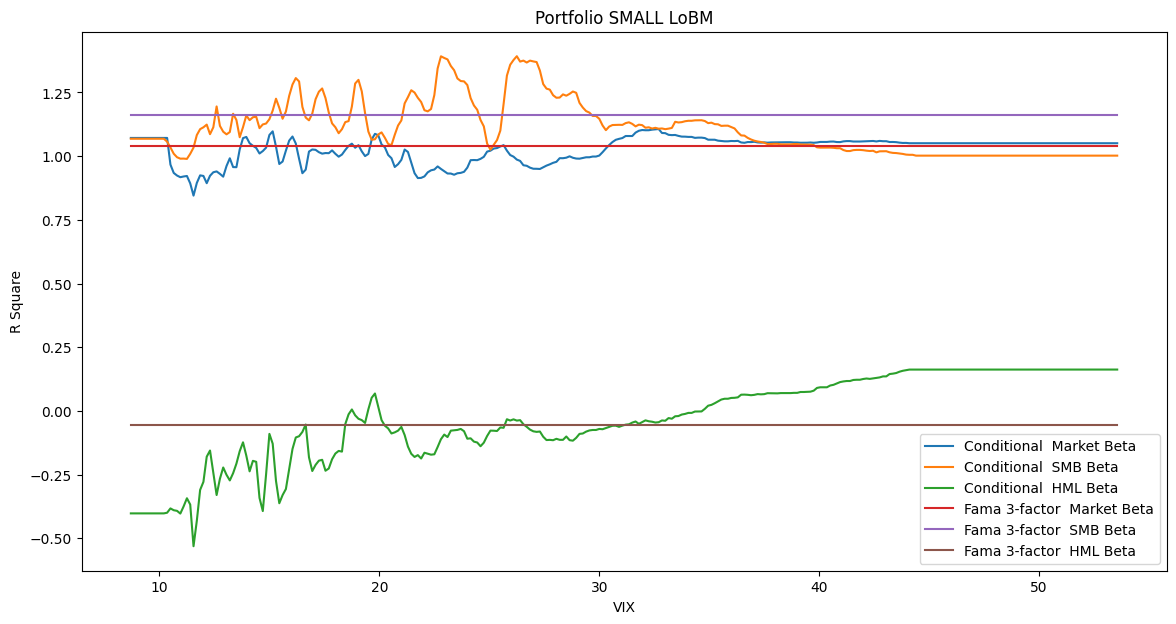

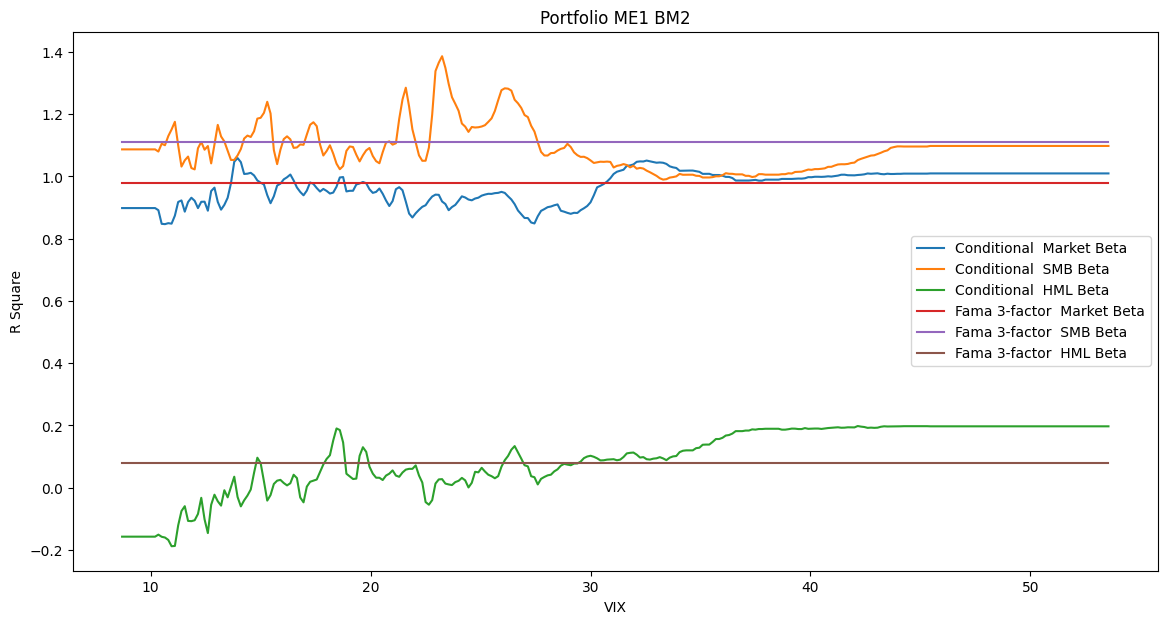

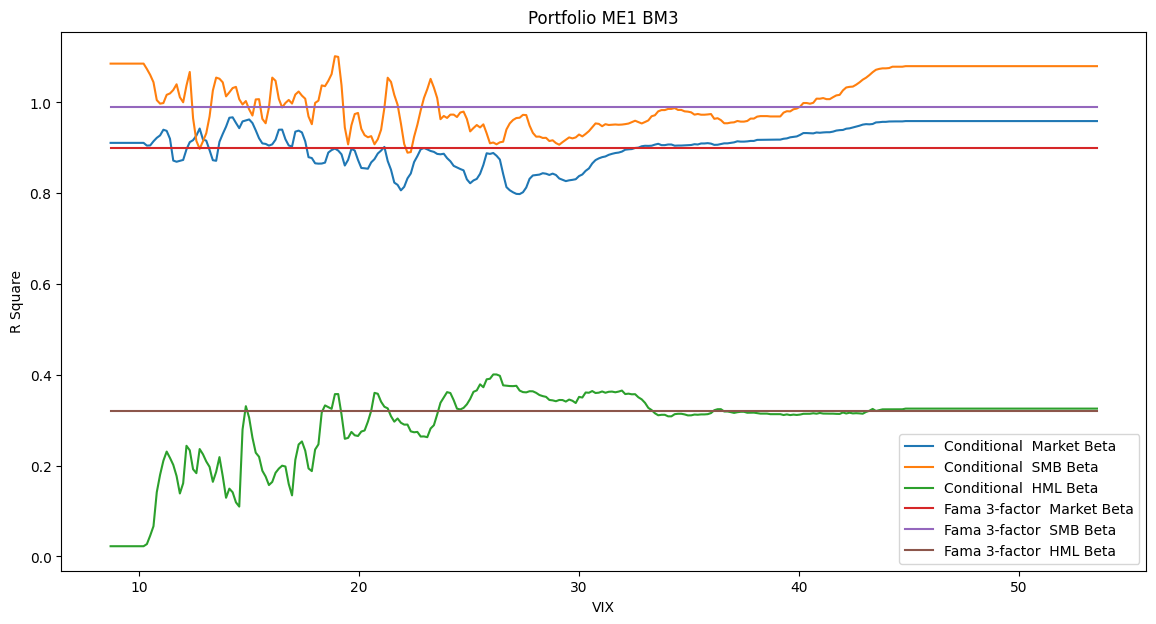

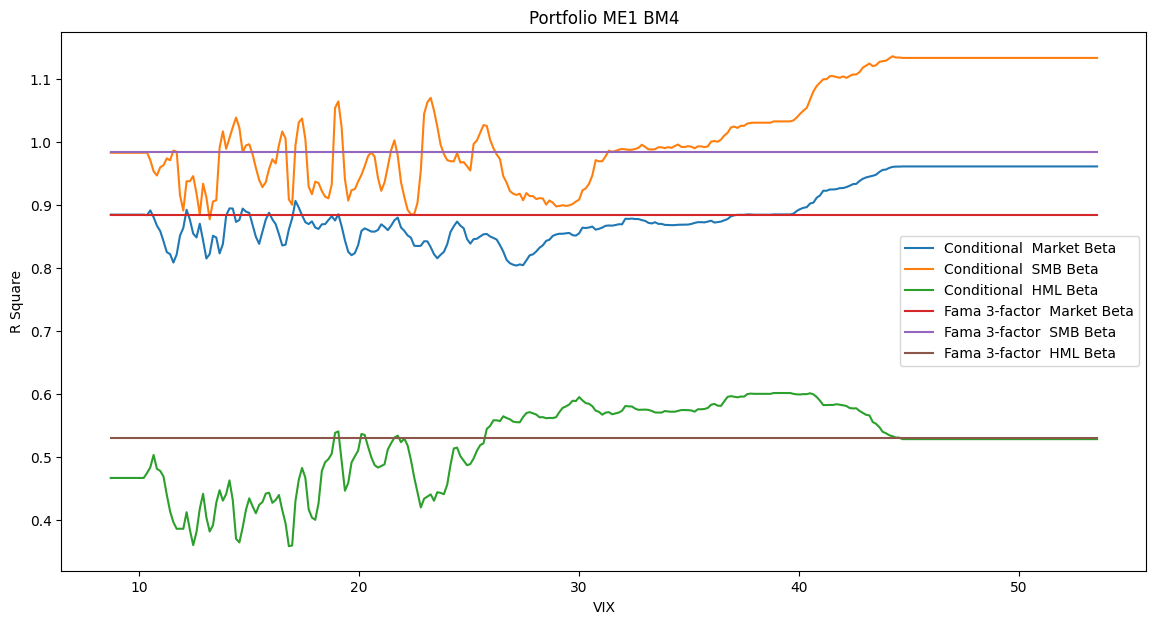

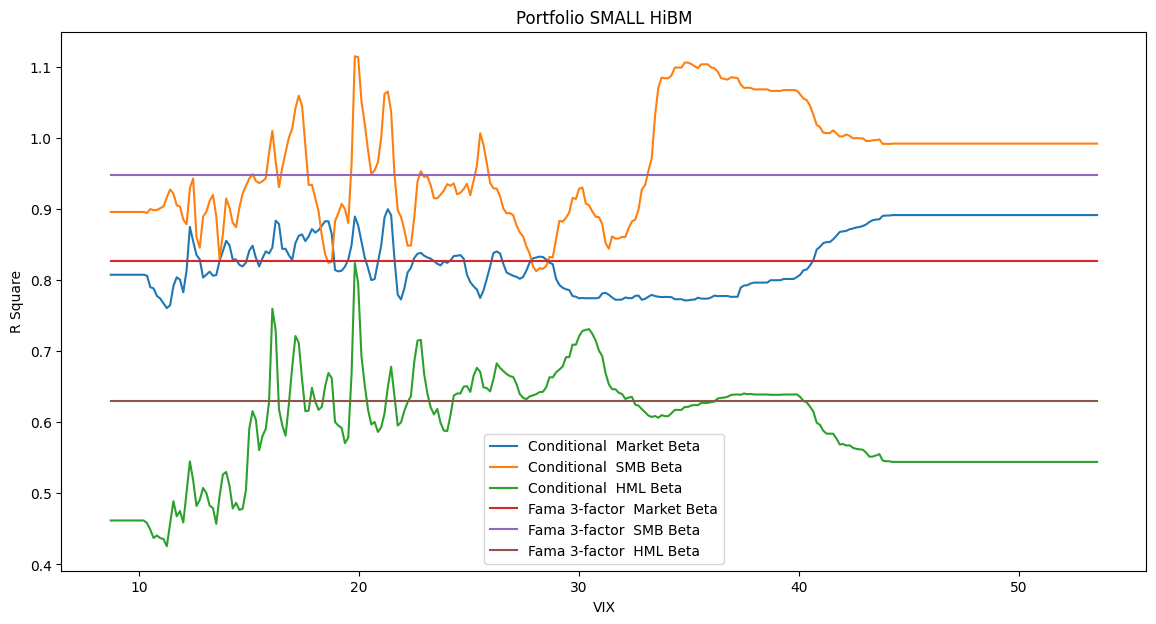

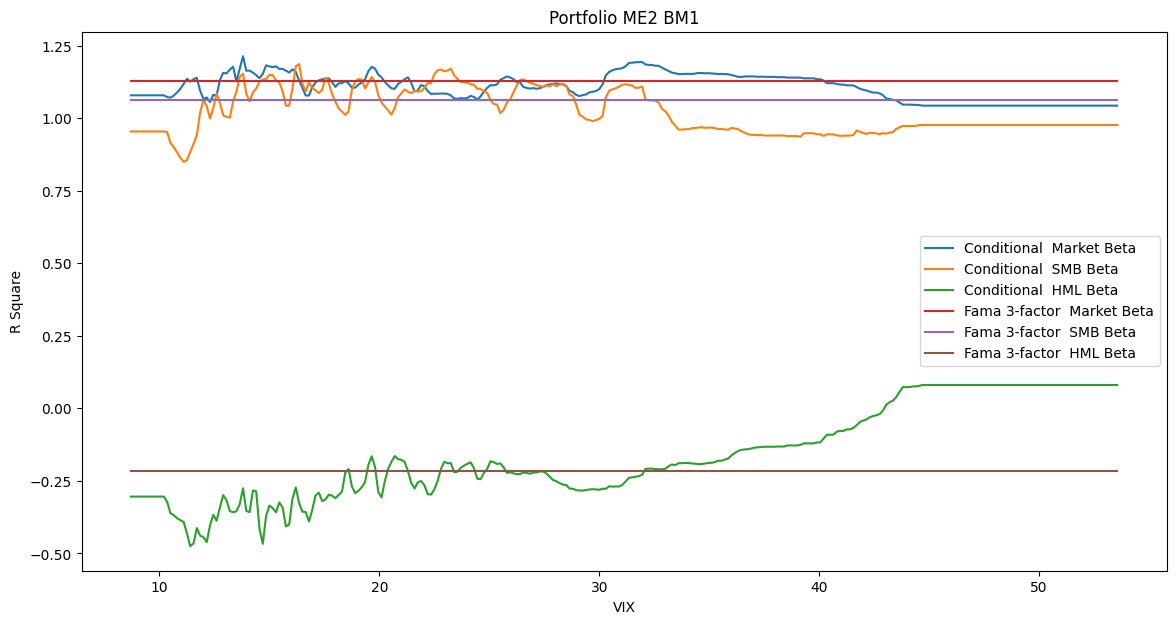

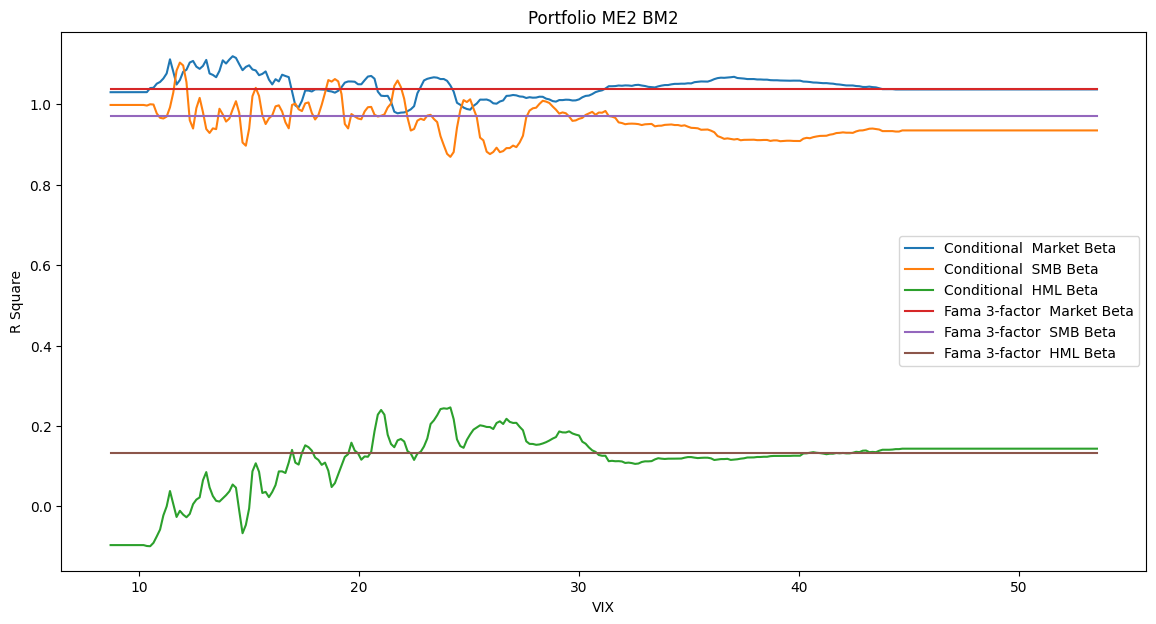

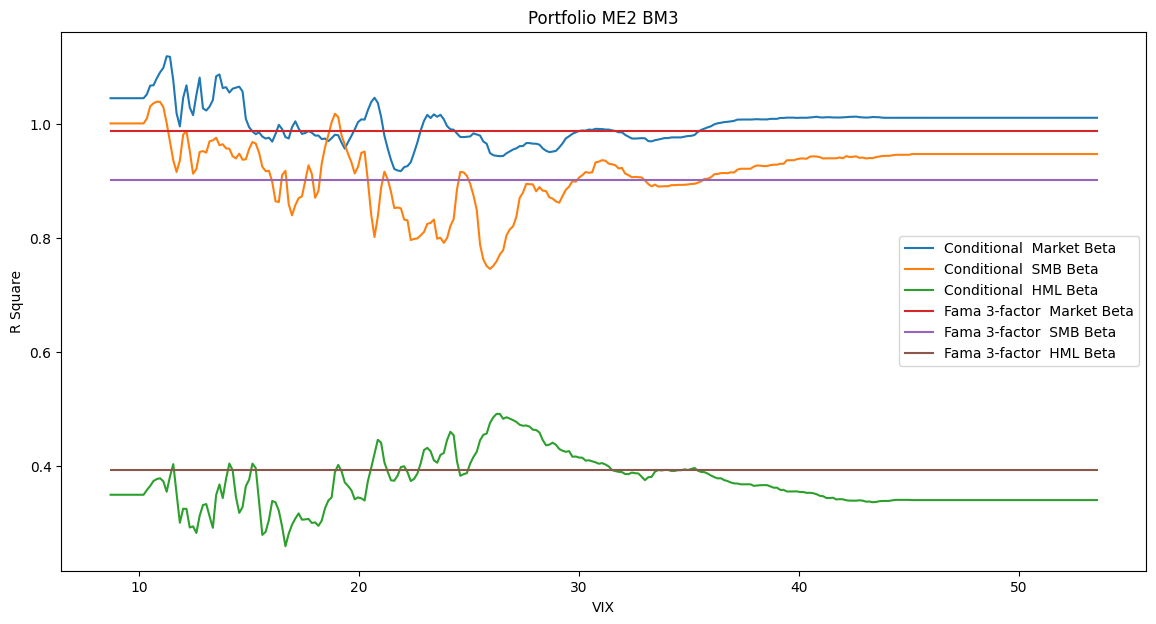

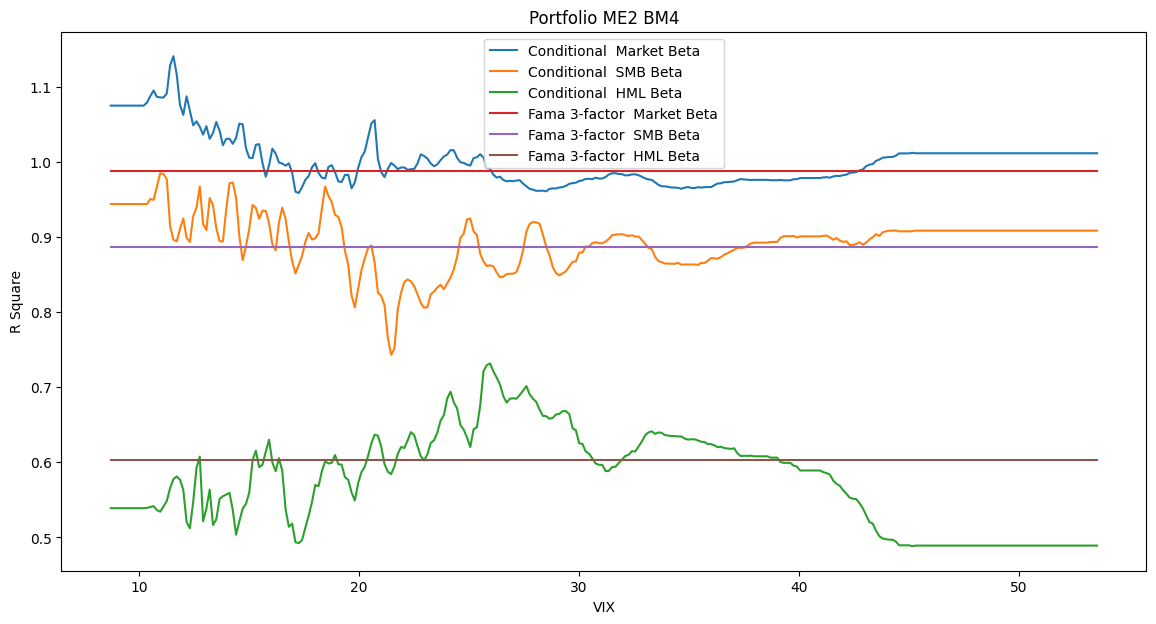

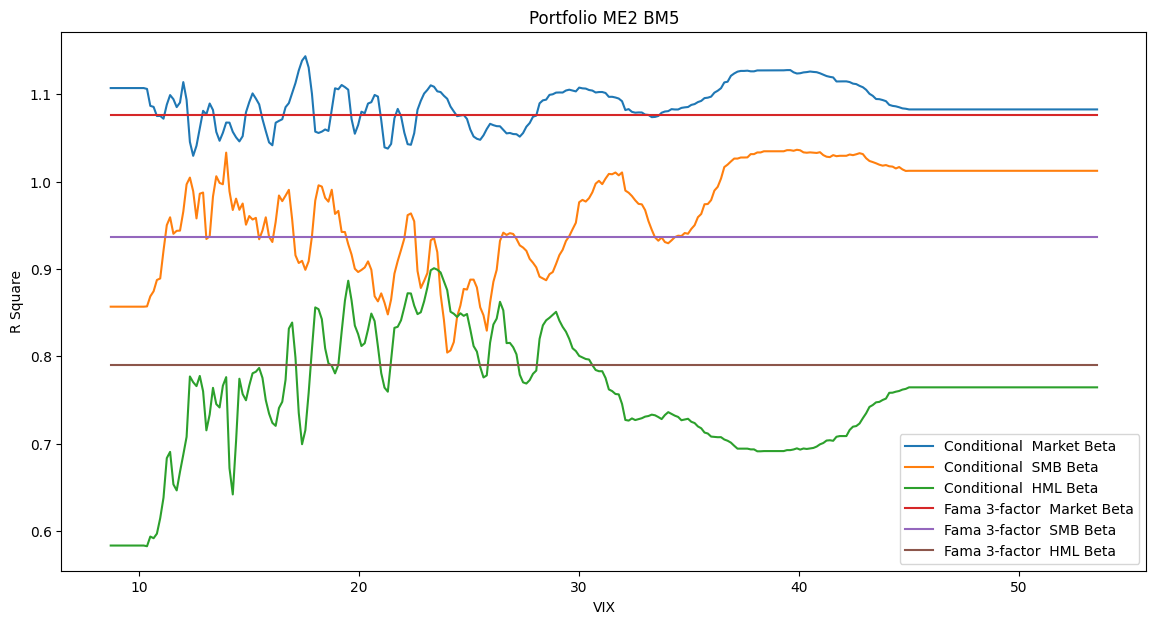

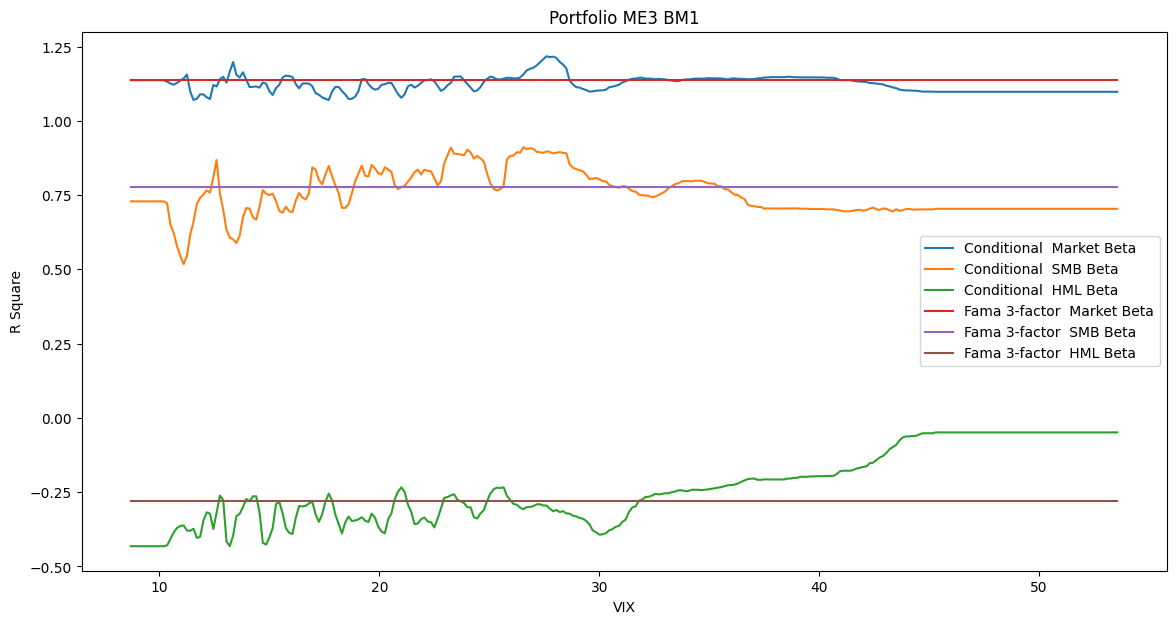

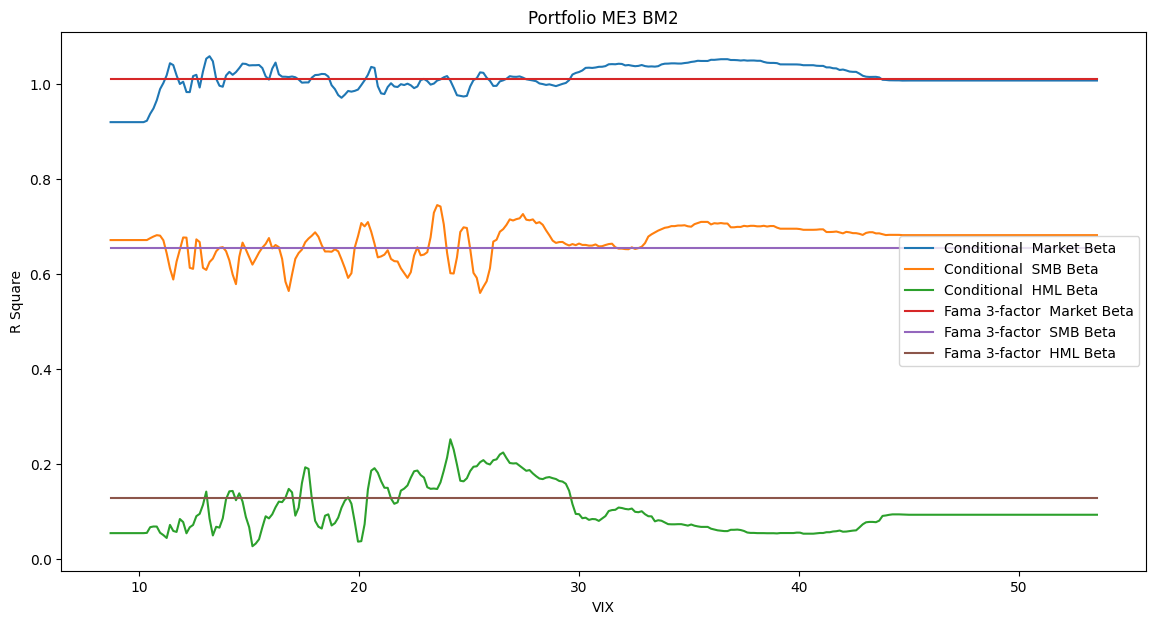

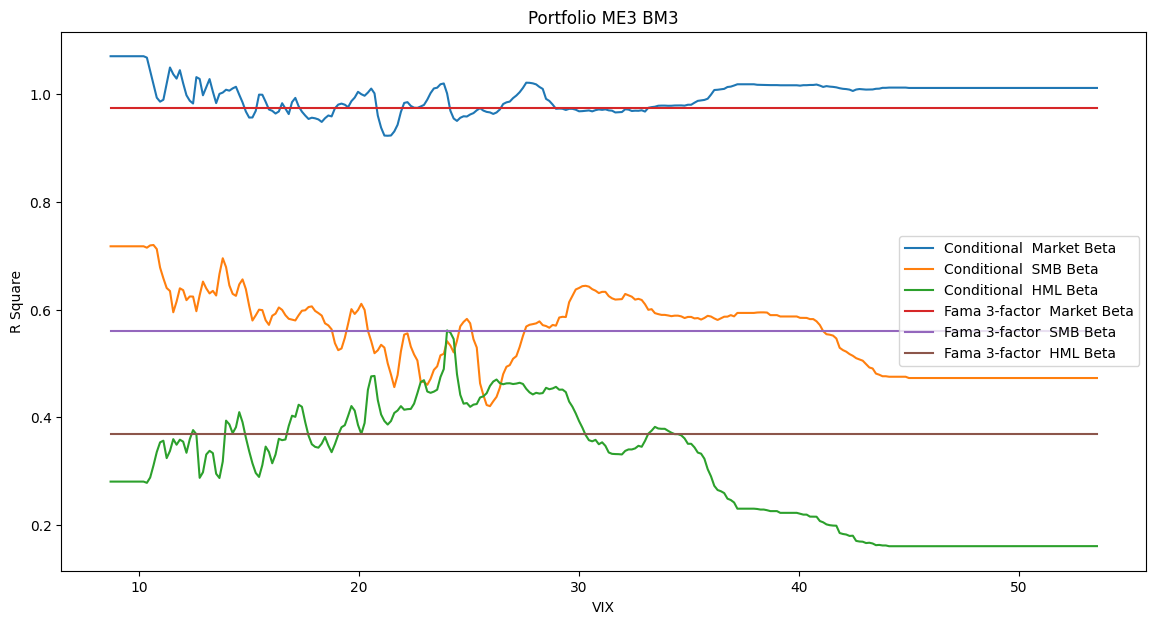

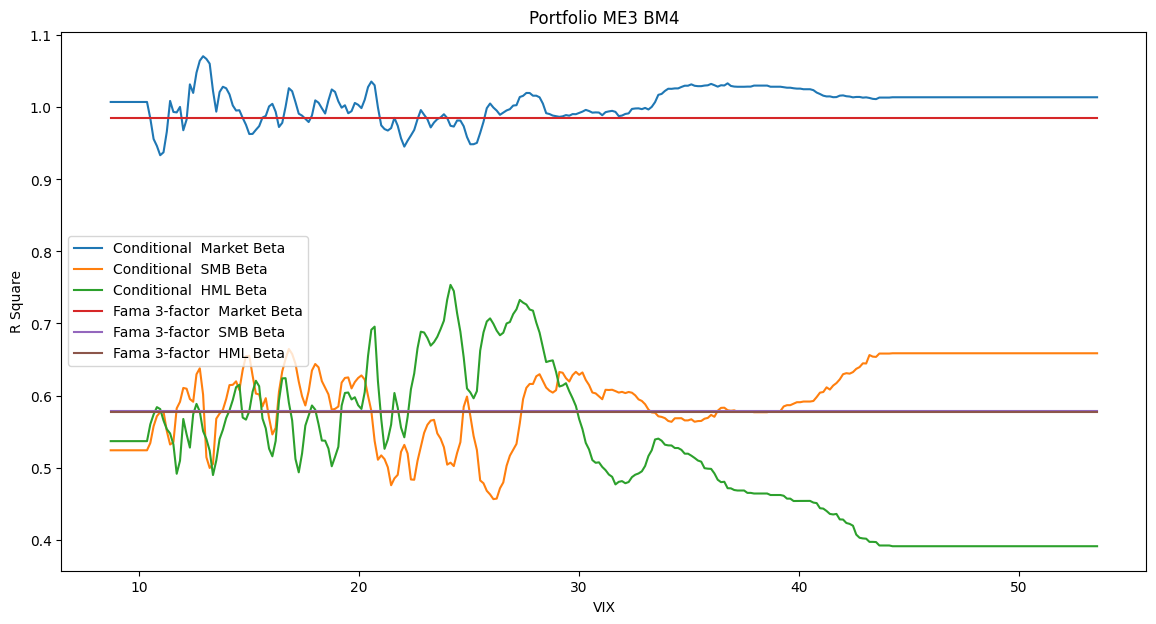

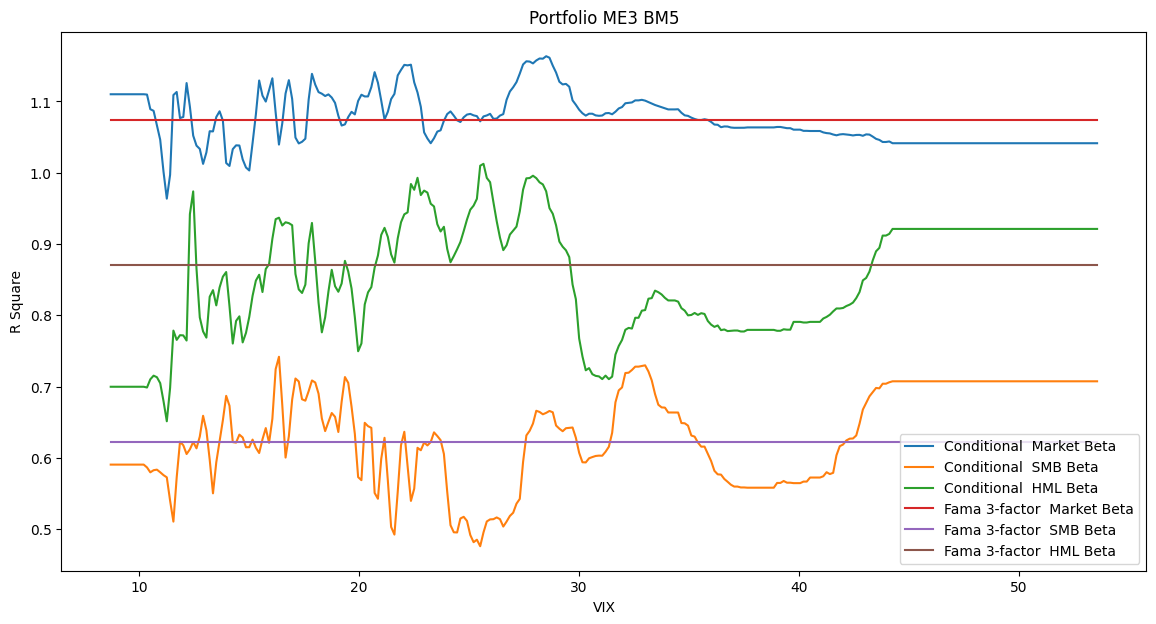

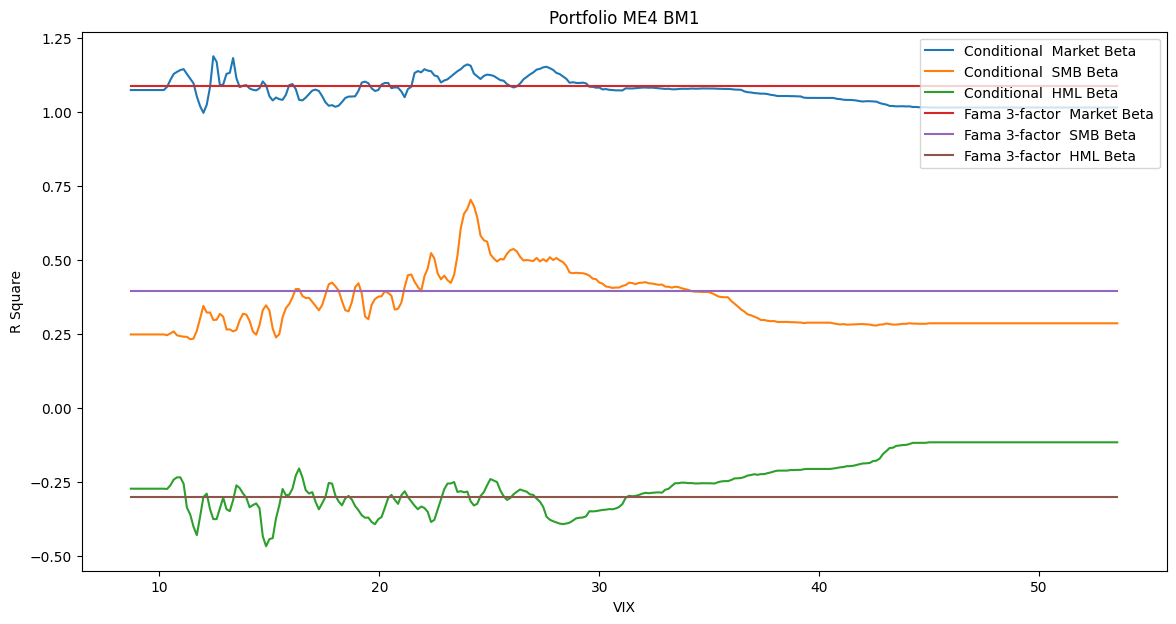

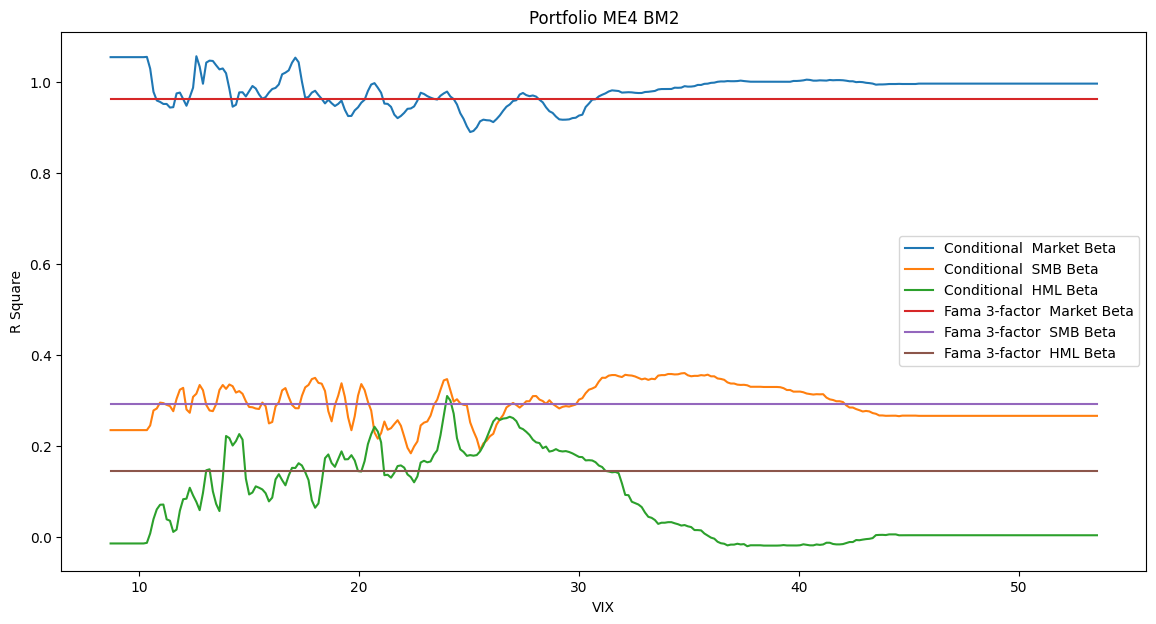

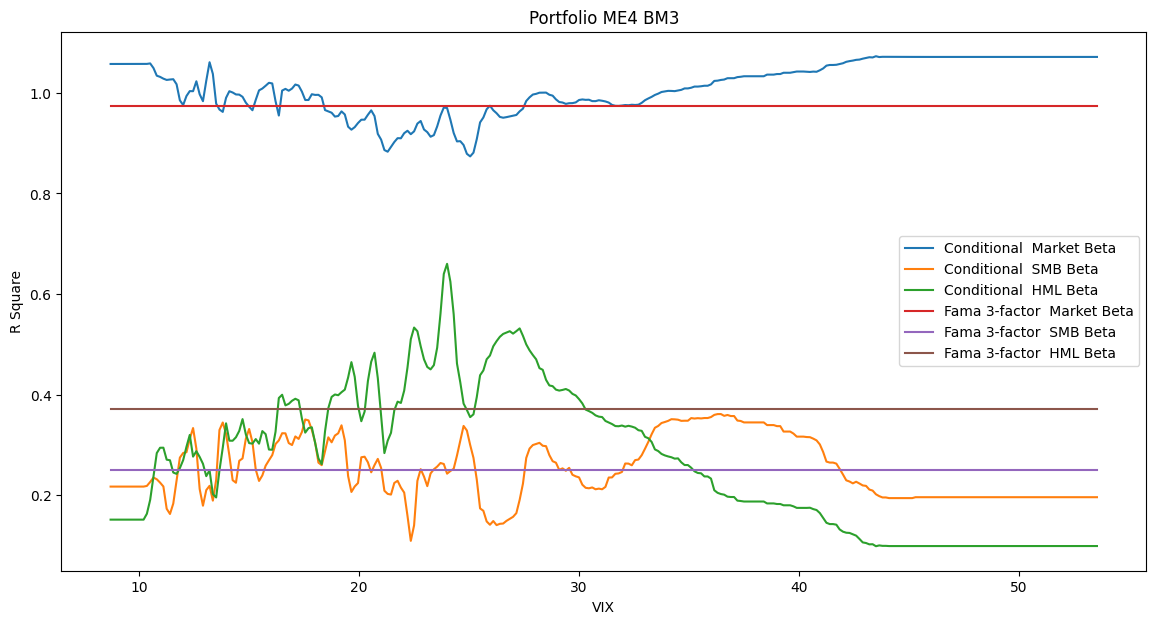

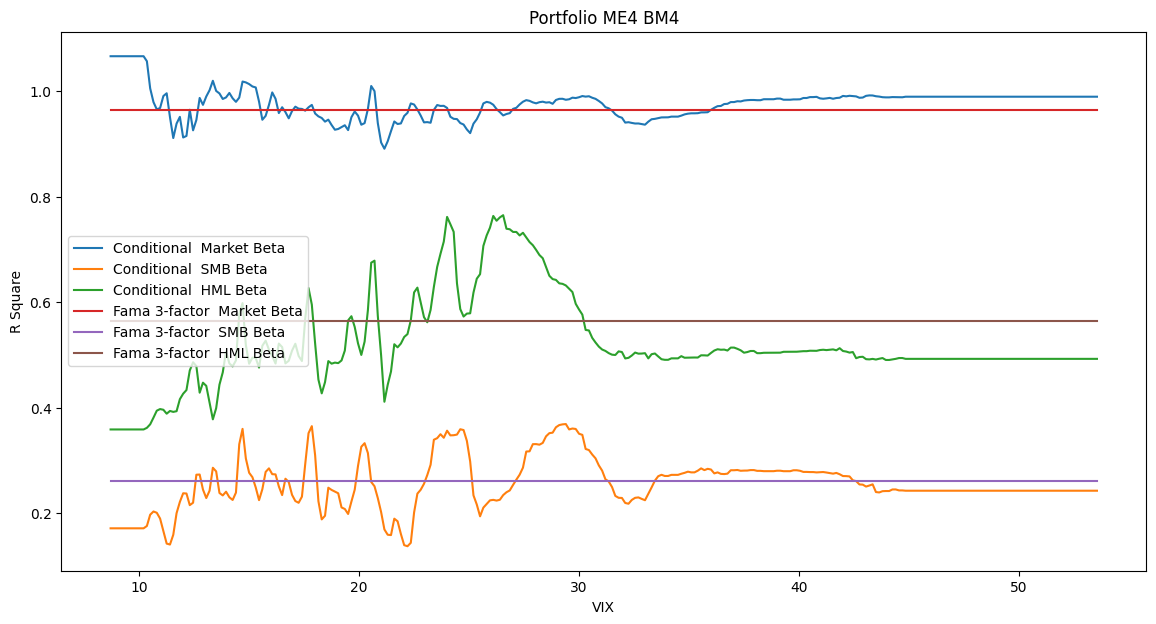

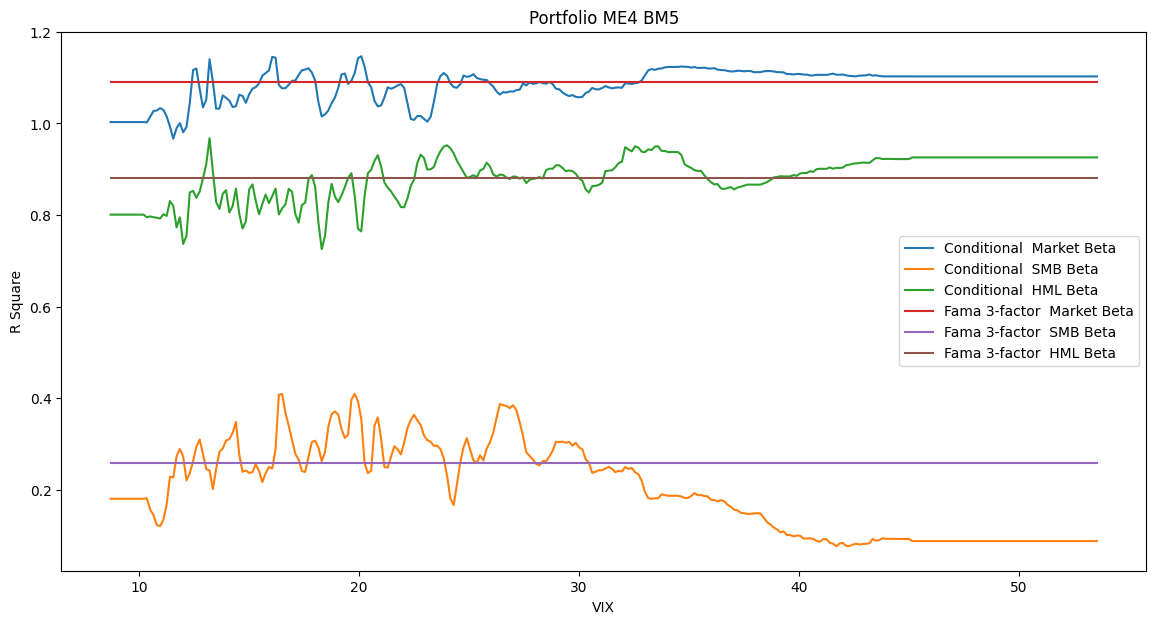

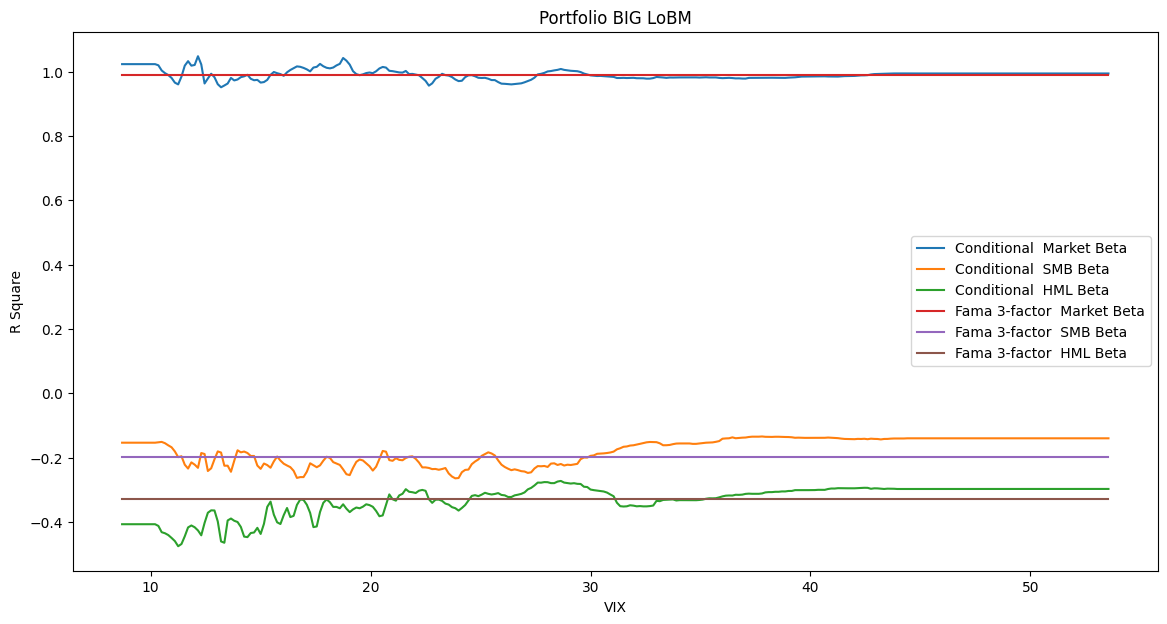

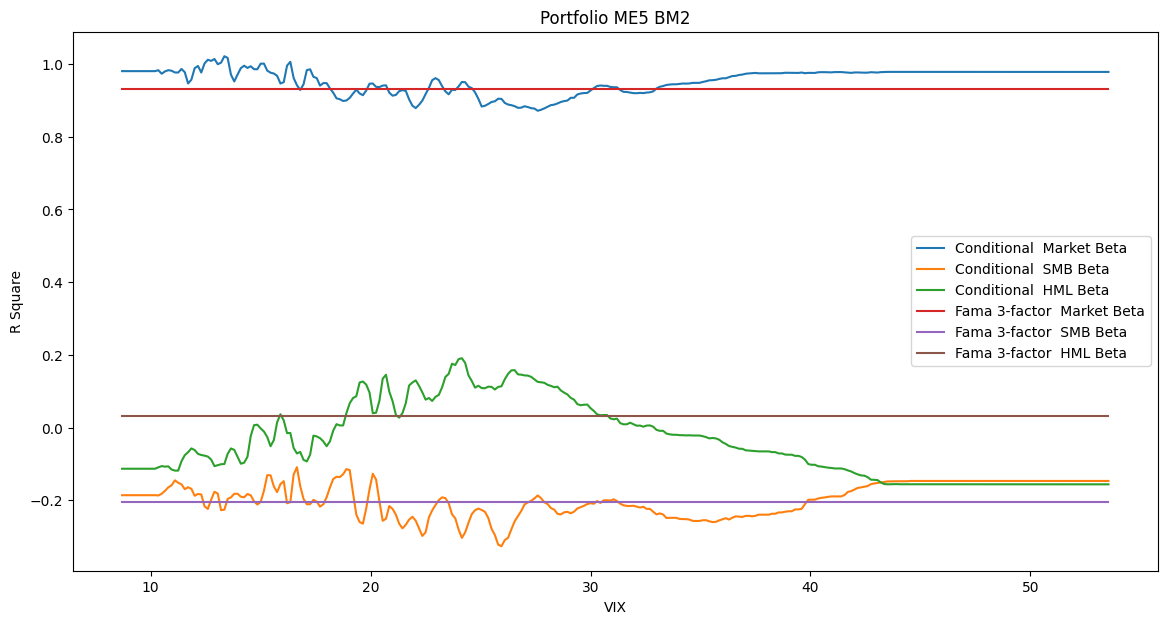

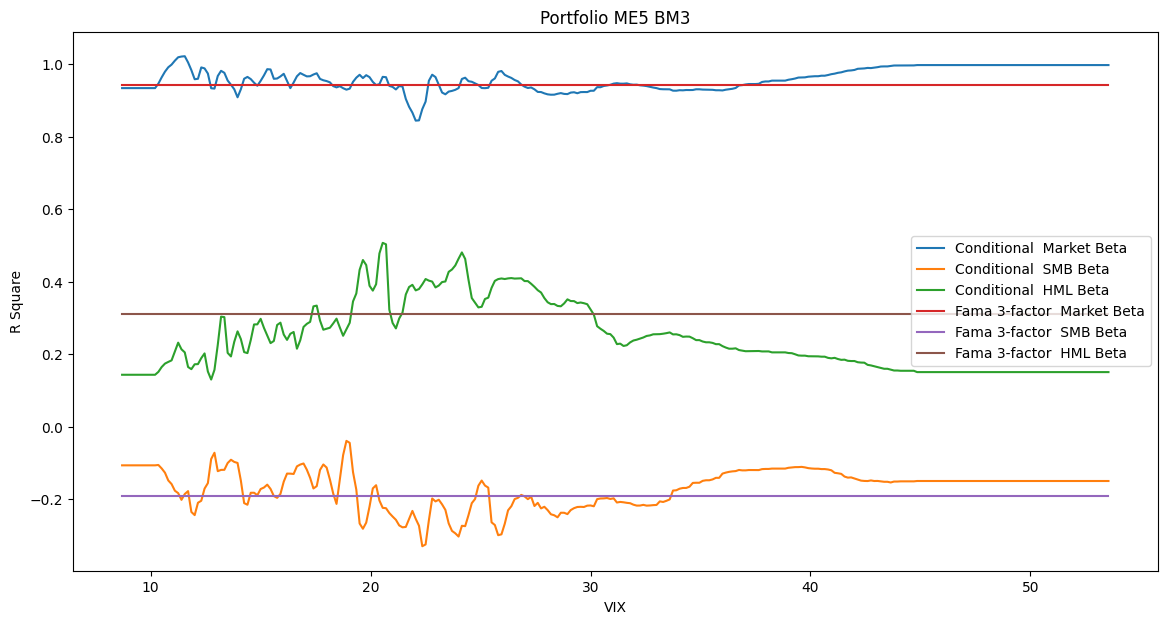

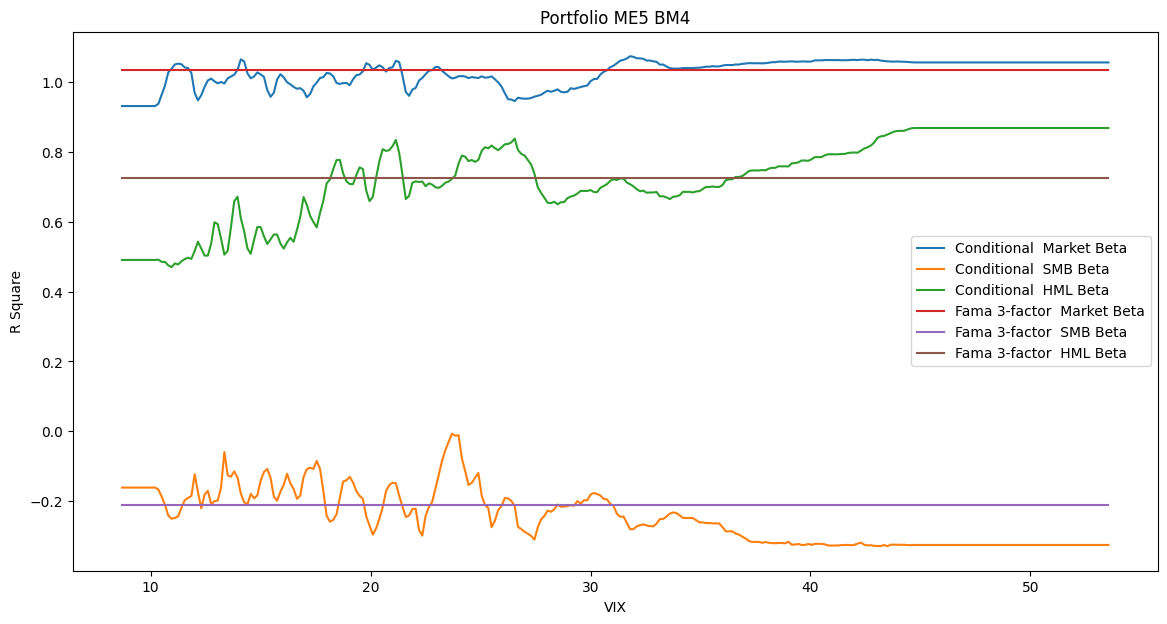

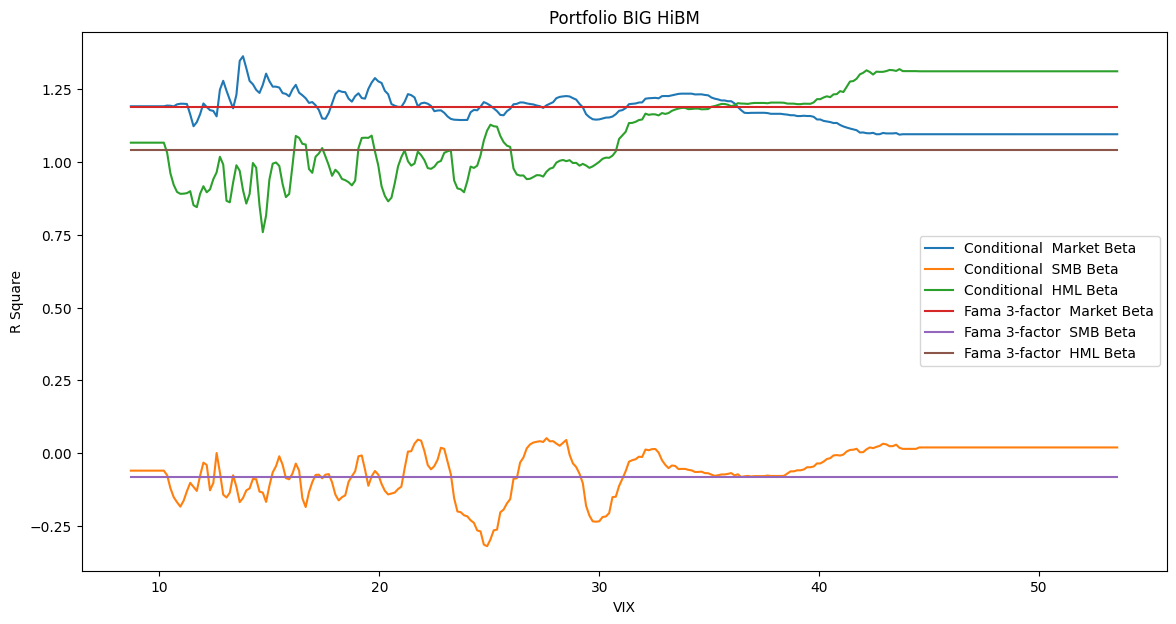

In [ ]:
test_data = np.array([[8.7 + i * 0.15] for i in range(300)])
result_beta = {}
for portfolio in excess_returns.columns:
    corr_bootstrap = []

    final_data = merged_data
    Y = final_data[portfolio] - final_data['RF']

    # Define the treatment variables (market excess return and additional factors)
    T = final_data[['Mkt-RF', 'SMB', 'HML']]

    # Define the covariates (features), including the VIX
    X = final_data[['VIX']]

    # Instantiate the Causal Forest model
    causal_forest = CausalForest(min_samples_leaf = 30)
    causal_forest.fit(X, sm.add_constant(T), Y)

    # Make predictions (treatment effects)
    beta_iM = np.squeeze(causal_forest.predict(test_data)[:, 1:4])


    data = pd.DataFrame({
        'Conditional  Market Beta': beta_iM[:,0],
        'Conditional  SMB Beta': beta_iM[:,1],
        'Conditional  HML Beta': beta_iM[:,2],
        'Fama 3-factor  Market Beta': capm_results[portfolio][0],
        'Fama 3-factor  SMB Beta': capm_results[portfolio][1],
        'Fama 3-factor  HML Beta': capm_results[portfolio][2],
    })
    
    plt.figure(figsize=(14, 7))
    for column in data.columns:
        plt.plot(np.squeeze(test_data), data[column], label=column)

    # Adding labels and title
    plt.xlabel('VIX')
    plt.ylabel('R Square')
    plt.title('Portfolio ' + portfolio)
    plt.legend()
    

    # Show the plot
    plt.show()

## $R^2$ analysis

In [ ]:
# Run Fama-French regression for each portfolio
n = np.shape(merged_data)[0]
for column in excess_returns.columns:
  model_rsqure = []
  for i in range(100):
    indices = np.random.choice(n, int(0.8 * n ), replace=True)
    Y = excess_returns[column][indices]
    X = merged_data[['Mkt-RF', 'SMB', 'HML']].iloc[indices , :]
    #X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(Y, X).fit()  # Fit the regression model
    model_rsqure.append(model.rsquared)
  capm_results[column] = np.array(model_rsqure)




In [ ]:
test_data = np.array([[8.7 + i * 0.15] for i in range(300)])
resutlsfama = {}
for portfolio in excess_returns.columns:
    corr_bootstrap = np.array([])
    for i in range(100):
        n = np.shape(merged_data)[0]
        indices = np.random.choice(n, int(0.8 * n), replace=True)
        final_data = merged_data.iloc[indices, :]
        Y = final_data[portfolio] - final_data['RF']

        # Define the treatment variables (market excess return and additional factors)
        T = final_data[['Mkt-RF', 'SMB', 'HML']]

        # Define the covariates (features), including the VIX
        X = final_data[['VIX']]

        # Instantiate the Causal Forest model
        causal_forest = CausalForest(min_samples_leaf = 30)
        causal_forest.fit(X, T, Y)

        # Make predictions (treatment effects)
        beta_iM = np.squeeze(causal_forest.predict(test_data)[:, 0:3])

        causal_forest = CausalForest(min_samples_leaf = 30)
        causal_forest.fit(X, Y, final_data[['Mkt-RF']])

        # Make predictions (treatment effects)
        beta_Mi1 = causal_forest.predict(test_data)[:, 0:1]

        causal_forest = CausalForest(min_samples_leaf = 30)
        causal_forest.fit(X, Y, final_data[[ 'SMB']])

        # Make predictions (treatment effects)
        beta_Mi2 = causal_forest.predict(test_data)[:, 0:1]


        causal_forest = CausalForest(min_samples_leaf = 30)
        causal_forest.fit(X, Y, final_data[['HML']])

        # Make predictions (treatment effects)
        beta_Mi3 = causal_forest.predict(test_data)[:, 0:1]
        cond_r_square = np.sum(beta_iM *  np.concatenate((beta_Mi1,beta_Mi2,beta_Mi3) , axis = 1) , axis=1)
        corr_bootstrap = np.append(corr_bootstrap, cond_r_square)

    t = np.reshape(corr_bootstrap, (100, 300))
    data = pd.DataFrame({'Condtional R sqaure' : np.mean(t, axis = 0) ,
        'Condtional R sqaure UB':  np.sort(t, axis=0)[2,:]
  ,

          'Condtional R sqaure LB' :np.sort(t, axis=0)[-3,:]  ,
        'Fama 3-factor R sqaure': np.ones(300) * np.mean(capm_results[portfolio]),
                        'Fama 3-factor R sqaure UB': np.ones(300) * np.sort(capm_results[portfolio])[2]
                       , 'Fama 3-factor R sqaure LB': np.ones(300) * np.sort(capm_results[portfolio])[-3]
                      })

    
    plt.figure(figsize=(14, 7))

    for column in data.columns:
        plt.plot(np.squeeze(test_data), data[column], label=column)

    # Adding labels and title
    plt.xlabel('VIX')
    plt.ylabel('R Square')
    plt.title('Portfolio ' + portfolio)
    plt.legend(fontsize=18, loc='lower right')
   

    # Show the plot
    plt.show()